In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [44]:
all_train_snp_all = pd.read_csv("./csv/all_train_snp_selected.csv")
validation_snp_all = pd.read_csv("./csv/validation_snp_selected.csv")

In [45]:
X_train_all_ = all_train_snp_all.drop(columns=["Unnamed: 0", "target"]).to_numpy()
X_val_all_ = validation_snp_all.drop(columns=["Unnamed: 0", "target"]).to_numpy()
y_all_train = all_train_snp_all["target"] - 1
y_val = validation_snp_all["target"] - 1

In [46]:
selector = SelectKBest(f_classif, k=40)
X_train_all_ = selector.fit_transform(X_train_all_, y_all_train)
X_val_all_ = selector.transform(X_val_all_)

In [47]:
all_train_pgs = pd.read_csv("./pgs_results_calculated/all_train_pgs.csv").drop(columns=["FID", "IID", "y"])
validation_pgs = pd.read_csv("./pgs_results_calculated/validation_pgs.csv").drop(columns=["FID", "IID", "y"])

In [48]:
X_train_pgs = all_train_pgs.to_numpy()
X_val_pgs = validation_pgs.to_numpy()
ss = StandardScaler()
X_train_pgs = ss.fit_transform(X_train_pgs)
X_val_pgs = ss.transform(X_val_pgs)

In [49]:
selector = SelectKBest(f_classif, k=19)
X_train_pgs = selector.fit_transform(X_train_pgs, y_all_train)
X_val_pgs = selector.transform(X_val_pgs)

In [50]:
def select_features(train_snp, test_snp, k=40):
    train_id = train_snp["Unnamed: 0"]
    train_target = train_snp["target"]
    test_id = test_snp["Unnamed: 0"]
    test_target = test_snp["target"]
    
    X_train = train_snp.drop(columns=["Unnamed: 0", "target"])
    y_train = train_snp["target"]
    X_test = test_snp.drop(columns=["Unnamed: 0", "target"])
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices]
    X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
    X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
    
    X_train_selected_df.insert(0, "Unnamed: 0", train_id.values)
    X_train_selected_df["target"] = train_target.values
    
    X_test_selected_df.insert(0, "Unnamed: 0", test_id.values)
    X_test_selected_df["target"] = test_target.values
    
    return X_train_selected_df, X_test_selected_df

In [51]:
train_snps = []
test_snps = []
train_pgss = []
test_pgss = []
for i in range(1, 6):
    train_snp = pd.read_csv(f"./csv/train_{i}_snp_selected.csv")
    y_train = train_snp["target"] - 1
    test_snp = pd.read_csv(f"./csv/test_{i}_snp_selected.csv")
    train_selected, test_selected = select_features(train_snp, test_snp, k=40)
    train_snps.append(train_selected)
    test_snps.append(test_selected)
    ss = StandardScaler()
    train_pgs = ss.fit_transform(pd.read_csv(f"./pgs_results_calculated/train_{i}_pgs.csv").drop(columns=["FID", "IID", "y"]).to_numpy())
    test_pgs = ss.transform(pd.read_csv(f"./pgs_results_calculated/test_{i}_pgs.csv").drop(columns=["FID", "IID", "y"]).to_numpy())
    selector = SelectKBest(f_classif, k=19)
    train_pgs = selector.fit_transform(train_pgs, y_train)
    test_pgs = selector.transform(test_pgs)
    train_pgss.append(train_pgs)
    test_pgss.append(test_pgs)

Регрессия на всех SNP

In [52]:
ss = StandardScaler()
X_train_all = ss.fit_transform(np.concatenate([X_train_all_, X_train_pgs], axis=1))
X_val_all = ss.transform(np.concatenate([X_val_all_, X_val_pgs], axis=1))

model_gb = LogisticRegression()
model_gb.fit(X_train_all, y_all_train)

y_pred_proba = model_gb.predict_proba(X_val_all)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC bigset: {roc_auc:.4f}')

ROC-AUC bigset: 0.7721


In [53]:
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = np.concatenate([train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), train_pgs], axis=1)
    X_val_ = np.concatenate([test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), test_pgs], axis=1)
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)

    model_gb = LogisticRegression()
    model_gb.fit(X_train, y_train)

    y_pred_proba = model_gb.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    rocs.append(roc_auc)
    print(f'ROC-AUC: {roc_auc:.4f}')
print("среднее", np.mean(rocs))

ROC-AUC: 0.7622
ROC-AUC: 0.7489
ROC-AUC: 0.7218
ROC-AUC: 0.6694
ROC-AUC: 0.7354
среднее 0.727524787379042


Градиентный бустинг на всех SNP

In [54]:
ss = StandardScaler()
X_train_all = ss.fit_transform(np.concatenate([X_train_all_, X_train_pgs], axis=1))
X_val_all = ss.transform(np.concatenate([X_val_all_, X_val_pgs], axis=1))

model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_all, y_all_train)

y_pred_proba = model_gb.predict_proba(X_val_all)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC bigset: {roc_auc:.4f}')

ROC-AUC bigset: 0.7354


In [55]:
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = np.concatenate([train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), train_pgs], axis=1)
    X_val_ = np.concatenate([test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), test_pgs], axis=1)
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)

    model_gb = GradientBoostingClassifier()
    model_gb.fit(X_train, y_train)

    y_pred_proba = model_gb.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    rocs.append(roc_auc)
    print(f'ROC-AUC: {roc_auc:.4f}')
print("среднее", np.mean(rocs))

ROC-AUC: 0.7504
ROC-AUC: 0.7202
ROC-AUC: 0.7389
ROC-AUC: 0.7043
ROC-AUC: 0.7549
среднее 0.7337237227808442


SVC на всех SNP

In [56]:
ss = StandardScaler()
X_train_all = ss.fit_transform(np.concatenate([X_train_all_, X_train_pgs], axis=1))
X_val_all = ss.transform(np.concatenate([X_val_all_, X_val_pgs], axis=1))

model_gb = SVC(probability=True)
model_gb.fit(X_train_all, y_all_train)

y_pred_proba = model_gb.predict_proba(X_val_all)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC bigset: {roc_auc:.4f}')

ROC-AUC bigset: 0.7424


In [57]:
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = np.concatenate([train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), train_pgs], axis=1)
    X_val_ = np.concatenate([test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), test_pgs], axis=1)
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)

    model_gb = SVC(probability=True)
    model_gb.fit(X_train, y_train)

    y_pred_proba = model_gb.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    rocs.append(roc_auc)
    print(f'ROC-AUC: {roc_auc:.4f}')
print("среднее", np.mean(rocs))

ROC-AUC: 0.7263
ROC-AUC: 0.7288
ROC-AUC: 0.7115
ROC-AUC: 0.6915
ROC-AUC: 0.7792
среднее 0.7274670129770875


Полносвязная сеть на всех snp

In [58]:
ss = StandardScaler()
X_train_all = ss.fit_transform(np.concatenate([X_train_all_, X_train_pgs], axis=1))
X_val_all = ss.transform(np.concatenate([X_val_all_, X_val_pgs], axis=1))

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

X_train_tensor = torch.FloatTensor(X_train_all)
y_train_tensor = torch.FloatTensor(y_all_train.values).reshape(-1, 1)

model = Net(X_train_all.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model.train()
for epoch in range(10):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val_all)
    y_pred_proba = model(X_val_tensor).numpy().flatten()

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


ROC-AUC autoencoded bigset: 0.7790


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = np.concatenate([train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), train_pgs], axis=1)
    X_val_ = np.concatenate([test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), test_pgs], axis=1)
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    
    model = Net(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model.train()
    for epoch in range(10):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        y_pred_proba = model(X_val_tensor).numpy().flatten()
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    rocs.append(roc_auc)
    print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7449
ROC-AUC autoencoded: 0.7622
ROC-AUC autoencoded: 0.7328
ROC-AUC autoencoded: 0.7230
ROC-AUC autoencoded: 0.7522
среднее 0.7430376082353283


Блок обучения с использованием классического автоэнкодера

С использованием логистической регрессии для классификации

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
def train_autoencoder(model, X_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, _ in train_loader:
            optimizer.zero_grad()
            reconstructed, _ = model(batch_x)
            loss = criterion(reconstructed, batch_x)
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent = model(X_tensor)
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    autoencoder = Autoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
    autoencoder = train_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
    
    X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
    X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
    
    logreg = LogisticRegression(C=C, max_iter=1000)
    logreg.fit(X_train_latent, y_train)
    
    y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = Autoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(C=best_params['C'], max_iter=1000)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 05:43:30,090] A new study created in memory with name: no-name-6c8af431-f6de-40ea-9acc-ac85937c8cc6
[I 2025-05-12 05:43:35,806] Trial 0 finished with value: 0.7705314009661834 and parameters: {'latent_dim': 63, 'hidden_dim': 107, 'lr': 0.00011106583986771314, 'epochs': 47, 'C': 0.0021606672097472077, 'dropout_rate': 0.48945666638017205}. Best is trial 0 with value: 0.7705314009661834.
[I 2025-05-12 05:43:41,437] Trial 1 finished with value: 0.7648378191856454 and parameters: {'latent_dim': 50, 'hidden_dim': 221, 'lr': 0.004853023049452625, 'epochs': 42, 'C': 2.8855869238203815, 'dropout_rate': 0.3126944993889007}. Best is trial 0 with value: 0.7705314009661834.
[I 2025-05-12 05:43:45,798] Trial 2 finished with value: 0.7788129744651483 and parameters: {'latent_dim': 29, 'hidden_dim': 195, 'lr': 0.0013074820228356802, 'epochs': 42, 'C': 0.017649490535465096, 'dropout_rate': 0.1686005541897902}. Best is trial 2 with value: 0.7788129744651483.
[I 2025-05-12 05:43:49,422] Tri

ROC-AUC autoencoded bigset: 0.7823


In [61]:
best_params

{'latent_dim': 27,
 'hidden_dim': 168,
 'lr': 0.0005640334952942813,
 'epochs': 26,
 'C': 0.027113157929723943,
 'dropout_rate': 0.166188585496128}

In [63]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)

    autoencoder = Autoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
    autoencoder = train_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
    
    X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
    X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
    
    logreg = LogisticRegression(C=best_params['C'], max_iter=1000)
    logreg.fit(X_train_latent, y_train)
    
    y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    rocs.append(roc_auc)
    print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7715
ROC-AUC autoencoded: 0.7801
ROC-AUC autoencoded: 0.7473
ROC-AUC autoencoded: 0.7297
ROC-AUC autoencoded: 0.7766
среднее 0.7610350410902782


с градиентным бустингом

In [64]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры автоэнкодера
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Параметры градиентного бустинга
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    rocs = []
    for i in range(3):
        autoencoder = Autoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = Autoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 05:45:14,680] A new study created in memory with name: no-name-2980a782-bb79-41cf-887f-4def00378bcb


[I 2025-05-12 05:45:55,589] Trial 0 finished with value: 0.7593359404953608 and parameters: {'latent_dim': 84, 'hidden_dim': 200, 'lr': 0.0006388102962847999, 'epochs': 13, 'dropout_rate': 0.30593953417020836, 'n_estimators': 334, 'max_depth': 3, 'learning_rate': 0.022957940442808987, 'subsample': 0.7878747897629108, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7593359404953608.
[I 2025-05-12 05:47:22,924] Trial 1 finished with value: 0.751111877923472 and parameters: {'latent_dim': 71, 'hidden_dim': 85, 'lr': 0.0003392358044519743, 'epochs': 38, 'dropout_rate': 0.156777688052391, 'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.048304696867927044, 'subsample': 0.6283578819643862, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7593359404953608.
[I 2025-05-12 05:49:05,563] Trial 2 finished with value: 0.7567479487769342 and parameters: {'latent_dim': 57, 'hidden_dim': 137, 'lr': 0.006676495365048187, 'epochs': 23, 

ROC-AUC autoencoded bigset: 0.7794


In [65]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = Autoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))

ROC-AUC autoencoded: 0.7379
ROC-AUC autoencoded: 0.7279
ROC-AUC autoencoded: 0.7371
ROC-AUC autoencoded: 0.7453
ROC-AUC autoencoded: 0.7640
ROC-AUC autoencoded: 0.7487
ROC-AUC autoencoded: 0.7313
ROC-AUC autoencoded: 0.7317
ROC-AUC autoencoded: 0.7370
ROC-AUC autoencoded: 0.7340
ROC-AUC autoencoded: 0.7254
ROC-AUC autoencoded: 0.7209
ROC-AUC autoencoded: 0.7113
ROC-AUC autoencoded: 0.7313
ROC-AUC autoencoded: 0.7157
ROC-AUC autoencoded: 0.7066
ROC-AUC autoencoded: 0.7042
ROC-AUC autoencoded: 0.7050
ROC-AUC autoencoded: 0.7044
ROC-AUC autoencoded: 0.6984
ROC-AUC autoencoded: 0.7668
ROC-AUC autoencoded: 0.7525
ROC-AUC autoencoded: 0.7782
ROC-AUC autoencoded: 0.7595
ROC-AUC autoencoded: 0.7506
среднее 0.7330400099780411


Теперь с SVC

In [66]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры автоэнкодера
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Параметры SVC
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = Autoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = Autoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if best_params['kernel'] in ['rbf', 'poly', 'sigmoid'] else 'scale',
    degree=best_params['degree'] if best_params['kernel'] == 'poly' else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:02:49,373] A new study created in memory with name: no-name-b5fc7571-d841-49ac-a184-67e486b5614b
[I 2025-05-12 06:02:54,209] Trial 0 finished with value: 0.630578559926386 and parameters: {'latent_dim': 87, 'hidden_dim': 191, 'lr': 0.0012527882948584835, 'epochs': 14, 'dropout_rate': 0.2725479564296007, 'C': 1.9657298584416383, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.630578559926386.
[I 2025-05-12 06:02:59,910] Trial 1 finished with value: 0.6972433095621501 and parameters: {'latent_dim': 70, 'hidden_dim': 234, 'lr': 0.0015311327643555016, 'epochs': 14, 'dropout_rate': 0.3328983472631857, 'C': 28.770943859471153, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 1 with value: 0.6972433095621501.
[I 2025-05-12 06:03:12,196] Trial 2 finished with value: 0.7297561536691971 and parameters: {'latent_dim': 32, 'hidden_dim': 119, 'lr': 0.003032040067324558, 'epochs': 30, 'dropout_rate': 0.4990933703431676, 'C': 0.10378849162022666, '

ROC-AUC autoencoded bigset: 0.7760


In [67]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = Autoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if best_params['kernel'] in ['rbf', 'poly', 'sigmoid'] else 'scale',
            degree=best_params['degree'] if best_params['kernel'] == 'poly' else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7818
ROC-AUC autoencoded: 0.7515
ROC-AUC autoencoded: 0.7437
ROC-AUC autoencoded: 0.7458
ROC-AUC autoencoded: 0.7661
ROC-AUC autoencoded: 0.7540
ROC-AUC autoencoded: 0.7840
ROC-AUC autoencoded: 0.7695
ROC-AUC autoencoded: 0.7798
ROC-AUC autoencoded: 0.7559
ROC-AUC autoencoded: 0.7482
ROC-AUC autoencoded: 0.7590
ROC-AUC autoencoded: 0.7264
ROC-AUC autoencoded: 0.7336
ROC-AUC autoencoded: 0.7613
ROC-AUC autoencoded: 0.7094
ROC-AUC autoencoded: 0.7267
ROC-AUC autoencoded: 0.6959
ROC-AUC autoencoded: 0.7216
ROC-AUC autoencoded: 0.7084
ROC-AUC autoencoded: 0.7495
ROC-AUC autoencoded: 0.7441
ROC-AUC autoencoded: 0.7343
ROC-AUC autoencoded: 0.7345
ROC-AUC autoencoded: 0.7403
среднее 0.745022075194766


С MLP

In [68]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

def train_mlp(model, X_train, y_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_mlp(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        predictions = model(X_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры автоэнкодера
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    
    # Параметры MLP
    hidden_dim_mlp = trial.suggest_int('hidden_dim_mlp', 32, 128)
    lr_mlp = trial.suggest_float('lr_mlp', 1e-4, 1e-2, log=True)
    batch_size_mlp = trial.suggest_categorical('batch_size_mlp', [16, 32, 64])
    epochs_mlp = trial.suggest_int('epochs_mlp', 10, 50)
    dropout_rate_mlp = trial.suggest_float('dropout_rate_mlp', 0.1, 0.5)
    
    rocs = []
    for i in range(3):
        autoencoder = Autoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_autoencoder(autoencoder, X_train, epochs_ae, batch_size, lr_ae)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], hidden_dim_mlp, dropout_rate_mlp)
        mlp = train_mlp(mlp, X_train_latent, y_train, epochs_mlp, batch_size_mlp, lr_mlp)
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = Autoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_autoencoder(autoencoder, X_train_all, best_params['epochs_ae'], 32, best_params['lr_ae'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
mlp = train_mlp(mlp, X_train_latent, y_all_train, best_params['epochs_mlp'], best_params['batch_size_mlp'], best_params['lr_mlp'])

y_pred_proba = predict_mlp(mlp, X_val_latent)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:09:38,422] A new study created in memory with name: no-name-c4efd536-64dd-44d6-b63a-00ee9cce4aea
[I 2025-05-12 06:09:53,742] Trial 0 finished with value: 0.7192124837052373 and parameters: {'latent_dim': 70, 'hidden_dim_ae': 114, 'lr_ae': 0.004107250369895147, 'epochs_ae': 43, 'dropout_rate_ae': 0.356202405349448, 'hidden_dim_mlp': 112, 'lr_mlp': 0.0021539876477346593, 'batch_size_mlp': 64, 'epochs_mlp': 43, 'dropout_rate_mlp': 0.20263084335730738}. Best is trial 0 with value: 0.7192124837052373.
[I 2025-05-12 06:10:02,196] Trial 1 finished with value: 0.7394755003450655 and parameters: {'latent_dim': 39, 'hidden_dim_ae': 147, 'lr_ae': 0.00140977958540418, 'epochs_ae': 22, 'dropout_rate_ae': 0.1730520761697238, 'hidden_dim_mlp': 80, 'lr_mlp': 0.0013549126947154351, 'batch_size_mlp': 64, 'epochs_mlp': 28, 'dropout_rate_mlp': 0.33050532120097886}. Best is trial 1 with value: 0.7394755003450655.
[I 2025-05-12 06:10:18,624] Trial 2 finished with value: 0.7578023157733303 a

ROC-AUC autoencoded bigset: 0.7844


In [69]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = Autoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_autoencoder(autoencoder, X_train, best_params['epochs_ae'], 32, best_params['lr_ae'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
        mlp = train_mlp(mlp, X_train_latent, y_train, best_params['epochs_mlp'], best_params['batch_size_mlp'], best_params['lr_mlp'])
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7688
ROC-AUC autoencoded: 0.7628
ROC-AUC autoencoded: 0.7632
ROC-AUC autoencoded: 0.7412
ROC-AUC autoencoded: 0.7567
ROC-AUC autoencoded: 0.7725
ROC-AUC autoencoded: 0.7747
ROC-AUC autoencoded: 0.7606
ROC-AUC autoencoded: 0.7631
ROC-AUC autoencoded: 0.7715
ROC-AUC autoencoded: 0.7468
ROC-AUC autoencoded: 0.7277
ROC-AUC autoencoded: 0.7468
ROC-AUC autoencoded: 0.7475
ROC-AUC autoencoded: 0.7552
ROC-AUC autoencoded: 0.7267
ROC-AUC autoencoded: 0.7195
ROC-AUC autoencoded: 0.7348
ROC-AUC autoencoded: 0.7225
ROC-AUC autoencoded: 0.7298
ROC-AUC autoencoded: 0.7796
ROC-AUC autoencoded: 0.7633
ROC-AUC autoencoded: 0.7786
ROC-AUC autoencoded: 0.7816
ROC-AUC autoencoded: 0.7632
среднее 0.7543517857237504


Блок с классическим автоэнкодером с второй классифицирующей головой

логситическая регрессия

In [70]:
class ClassifyingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(ClassifyingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        classification = self.classifier(latent)
        return reconstructed, latent, classification

def train_classifying_autoencoder(model, X_train, y_train, epochs, batch_size, lr, recon_weight, class_weight):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            reconstructed, _, classification = model(batch_x)
            
            recon_loss = recon_criterion(reconstructed, batch_x)
            class_loss = class_criterion(classification, batch_y)
            
            loss = recon_weight * recon_loss + class_weight * class_loss
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent, _ = model(X_tensor)
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры автоэнкодера
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Веса для объединенной функции потерь
    recon_weight = trial.suggest_float('recon_weight', 0.1, 0.9)
    class_weight = 1.0 - recon_weight
    
    # Параметры логистической регрессии
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, recon_weight, class_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(C=best_params['C'], max_iter=1000, random_state=42)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')

[I 2025-05-12 06:15:52,602] A new study created in memory with name: no-name-49435977-5f55-4594-a037-772cc8ea16cd
[I 2025-05-12 06:16:10,482] Trial 0 finished with value: 0.6157503258952534 and parameters: {'latent_dim': 95, 'hidden_dim': 183, 'lr': 0.006577630294304436, 'epochs': 49, 'dropout_rate': 0.47441377509145444, 'recon_weight': 0.13849671815130052, 'C': 6.3465769028642445}. Best is trial 0 with value: 0.6157503258952534.
[I 2025-05-12 06:16:26,308] Trial 1 finished with value: 0.6928533087953378 and parameters: {'latent_dim': 20, 'hidden_dim': 230, 'lr': 0.0034229236324209897, 'epochs': 44, 'dropout_rate': 0.20186191802150302, 'recon_weight': 0.2827226666883006, 'C': 0.01853193107909476}. Best is trial 1 with value: 0.6928533087953378.
[I 2025-05-12 06:16:37,200] Trial 2 finished with value: 0.6303772716816195 and parameters: {'latent_dim': 78, 'hidden_dim': 181, 'lr': 0.008955111118752147, 'epochs': 30, 'dropout_rate': 0.1793422865510065, 'recon_weight': 0.514404440124913, 'C

ROC-AUC autoencoded bigset: 0.7545


In [71]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(C=best_params['C'], max_iter=1000, random_state=42)
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7381
ROC-AUC autoencoded: 0.7544
ROC-AUC autoencoded: 0.7246
ROC-AUC autoencoded: 0.7405
ROC-AUC autoencoded: 0.7507
ROC-AUC autoencoded: 0.7894
ROC-AUC autoencoded: 0.7705
ROC-AUC autoencoded: 0.7552
ROC-AUC autoencoded: 0.7666
ROC-AUC autoencoded: 0.7613
ROC-AUC autoencoded: 0.7287
ROC-AUC autoencoded: 0.7284
ROC-AUC autoencoded: 0.7267
ROC-AUC autoencoded: 0.7662
ROC-AUC autoencoded: 0.7185
ROC-AUC autoencoded: 0.7156
ROC-AUC autoencoded: 0.6846
ROC-AUC autoencoded: 0.7050
ROC-AUC autoencoded: 0.6913
ROC-AUC autoencoded: 0.7150
ROC-AUC autoencoded: 0.7716
ROC-AUC autoencoded: 0.7492
ROC-AUC autoencoded: 0.7411
ROC-AUC autoencoded: 0.7666
ROC-AUC autoencoded: 0.7337
среднее 0.7397349137436232


Градиентный бустинг

In [72]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры автоэнкодера
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Веса для объединенной функции потерь
    recon_weight = trial.suggest_float('recon_weight', 0.1, 0.9)
    class_weight = 1.0 - recon_weight
    
    # Параметры градиентного бустинга
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, recon_weight, class_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')

[I 2025-05-12 06:19:39,876] A new study created in memory with name: no-name-900828db-f4ed-471e-a71f-71770c39e0ce
[I 2025-05-12 06:20:26,236] Trial 0 finished with value: 0.7117168928763133 and parameters: {'latent_dim': 80, 'hidden_dim': 209, 'lr': 0.000253666386046076, 'epochs': 17, 'dropout_rate': 0.4379253978599863, 'recon_weight': 0.6470045563852512, 'n_estimators': 492, 'max_depth': 4, 'learning_rate': 0.2954080344910506, 'subsample': 0.6045057239868353, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7117168928763133.
[I 2025-05-12 06:20:56,005] Trial 1 finished with value: 0.6435856146001074 and parameters: {'latent_dim': 15, 'hidden_dim': 167, 'lr': 0.008303442896611179, 'epochs': 30, 'dropout_rate': 0.3165962903513129, 'recon_weight': 0.15877667195642636, 'n_estimators': 309, 'max_depth': 8, 'learning_rate': 0.08570807326251753, 'subsample': 0.7068066070727819, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.711716

ROC-AUC autoencoded bigset: 0.7371


In [73]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7386
ROC-AUC autoencoded: 0.7220
ROC-AUC autoencoded: 0.7180
ROC-AUC autoencoded: 0.7447
ROC-AUC autoencoded: 0.7162
ROC-AUC autoencoded: 0.7026
ROC-AUC autoencoded: 0.7276
ROC-AUC autoencoded: 0.7174
ROC-AUC autoencoded: 0.7177
ROC-AUC autoencoded: 0.7017
ROC-AUC autoencoded: 0.7012
ROC-AUC autoencoded: 0.6924
ROC-AUC autoencoded: 0.6988
ROC-AUC autoencoded: 0.7206
ROC-AUC autoencoded: 0.7081
ROC-AUC autoencoded: 0.6827
ROC-AUC autoencoded: 0.7035
ROC-AUC autoencoded: 0.6942
ROC-AUC autoencoded: 0.6823
ROC-AUC autoencoded: 0.6874
ROC-AUC autoencoded: 0.7273
ROC-AUC autoencoded: 0.7498
ROC-AUC autoencoded: 0.7655
ROC-AUC autoencoded: 0.7358
ROC-AUC autoencoded: 0.7346
среднее 0.7156351422639271


SVM

In [74]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    recon_weight = trial.suggest_float('recon_weight', 0.1, 0.9)
    class_weight = 1.0 - recon_weight
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, recon_weight, class_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:34:46,348] A new study created in memory with name: no-name-0bc86201-b40a-4ea8-8f75-dbbcdf006ffa
[I 2025-05-12 06:34:50,432] Trial 0 finished with value: 0.6192584924468982 and parameters: {'latent_dim': 22, 'hidden_dim': 183, 'lr': 0.001203425276754481, 'epochs': 11, 'dropout_rate': 0.1830486340323197, 'recon_weight': 0.18449062706393207, 'C': 0.8905755301441848, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.6192584924468982.
[I 2025-05-12 06:35:06,830] Trial 1 finished with value: 0.7483321831147919 and parameters: {'latent_dim': 68, 'hidden_dim': 164, 'lr': 0.00010030977098521204, 'epochs': 43, 'dropout_rate': 0.12580084789311952, 'recon_weight': 0.6617056800261307, 'C': 0.6925976489534625, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.7483321831147919.
[I 2025-05-12 06:35:14,552] Trial 2 finished with value: 0.7088413465225059 and parameters: {'latent_dim': 72, 'hidden_dim': 140, 'lr': 0.00020370564317560917, 'epochs': 19, 

ROC-AUC autoencoded bigset: 0.7459


In [75]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7480
ROC-AUC autoencoded: 0.7383
ROC-AUC autoencoded: 0.7365
ROC-AUC autoencoded: 0.7363
ROC-AUC autoencoded: 0.7254
ROC-AUC autoencoded: 0.7315
ROC-AUC autoencoded: 0.7532
ROC-AUC autoencoded: 0.7482
ROC-AUC autoencoded: 0.7440
ROC-AUC autoencoded: 0.7367
ROC-AUC autoencoded: 0.7224
ROC-AUC autoencoded: 0.7334
ROC-AUC autoencoded: 0.7278
ROC-AUC autoencoded: 0.7312
ROC-AUC autoencoded: 0.7317
ROC-AUC autoencoded: 0.6991
ROC-AUC autoencoded: 0.6999
ROC-AUC autoencoded: 0.6914
ROC-AUC autoencoded: 0.6882
ROC-AUC autoencoded: 0.7051
ROC-AUC autoencoded: 0.7920
ROC-AUC autoencoded: 0.7878
ROC-AUC autoencoded: 0.7801
ROC-AUC autoencoded: 0.7824
ROC-AUC autoencoded: 0.7757
среднее 0.7378397401928545


MLP

In [76]:
class CombinedClassifier(nn.Module):
    def __init__(self, autoencoder, pgs_input_dim, hidden_dim=64, dropout_rate=0.2):
        super(CombinedClassifier, self).__init__()
        self.autoencoder = autoencoder
        self.pgs_branch = nn.Sequential(
            nn.Linear(pgs_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        latent_dim = list(autoencoder.classifier[0].parameters())[0].shape[1]
        self.combined_classifier = nn.Sequential(
            nn.Linear(hidden_dim // 2 + latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x_snp, x_pgs):
        _, latent, _ = self.autoencoder(x_snp)
        pgs_features = self.pgs_branch(x_pgs)
        combined = torch.cat([latent, pgs_features], dim=1)
        output = self.combined_classifier(combined)
        return output

def train_combined_classifier(model, X_train_snp, X_train_pgs, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_snp_tensor = torch.FloatTensor(X_train_snp).to(device)
    X_train_pgs_tensor = torch.FloatTensor(X_train_pgs).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_snp_tensor, X_train_pgs_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCELoss()
    
    # Этап 1: Заморозить автоэнкодер и его голову
    for param in model.autoencoder.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    model.train()
    for epoch in range(epochs_freeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Этап 2: Разморозить всё и обучать вместе
    for param in model.autoencoder.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.parameters(), lr=lr/10)  # Уменьшаем скорость обучения для всей сети
    
    for epoch in range(epochs_unfreeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_combined(model, X_snp, X_pgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_snp_tensor = torch.FloatTensor(X_snp).to(device)
    X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
    
    with torch.no_grad():
        predictions = model(X_snp_tensor, X_pgs_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    hidden_dim_combined = trial.suggest_int('hidden_dim_combined', 32, 128)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    lr_combined = trial.suggest_float('lr_combined', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    epochs_freeze = trial.suggest_int('epochs_freeze', 5, 20)
    epochs_unfreeze = trial.suggest_int('epochs_unfreeze', 5, 20)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    dropout_rate_combined = trial.suggest_float('dropout_rate_combined', 0.1, 0.5)
    
    recon_weight = trial.suggest_float('recon_weight', 0.1, 0.9)
    class_weight = 1.0 - recon_weight
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_classifying_autoencoder(autoencoder, X_train, y_train, epochs_ae, batch_size, lr_ae, recon_weight, class_weight)
        
        combined_model = CombinedClassifier(autoencoder, X_pgs_train.shape[1], hidden_dim_combined, dropout_rate_combined)
        combined_model = train_combined_classifier(combined_model, X_train, X_pgs_train, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr_combined)
        
        y_pred_proba = predict_combined(combined_model, X_val, X_pgs_val)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_classifying_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs_ae'], 32, 
    best_params['lr_ae'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
)

combined_model = CombinedClassifier(autoencoder, X_train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
combined_model = train_combined_classifier(
    combined_model, X_train_all, X_train_pgs, y_all_train, 
    best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
)

y_pred_proba = predict_combined(combined_model, X_val_all, X_val_pgs)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:39:59,151] A new study created in memory with name: no-name-9cc95721-131c-4ef1-9fba-e7581ba05f07
[I 2025-05-12 06:40:23,775] Trial 0 finished with value: 0.7589908749329038 and parameters: {'latent_dim': 14, 'hidden_dim_ae': 171, 'hidden_dim_combined': 39, 'lr_ae': 0.00020185556002551302, 'lr_combined': 0.00020202240781551676, 'epochs_ae': 45, 'epochs_freeze': 12, 'epochs_unfreeze': 8, 'dropout_rate_ae': 0.35795717343316846, 'dropout_rate_combined': 0.23813131647432237, 'recon_weight': 0.4827934403996471}. Best is trial 0 with value: 0.7589908749329038.
[I 2025-05-12 06:40:48,198] Trial 1 finished with value: 0.7250594279579786 and parameters: {'latent_dim': 50, 'hidden_dim_ae': 143, 'hidden_dim_combined': 73, 'lr_ae': 0.0010011672596565537, 'lr_combined': 0.0008923569558743225, 'epochs_ae': 48, 'epochs_freeze': 5, 'epochs_unfreeze': 14, 'dropout_rate_ae': 0.49034498034725027, 'dropout_rate_combined': 0.44734175487185857, 'recon_weight': 0.11241272087487691}. Best is t

ROC-AUC autoencoded bigset: 0.7757


In [77]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_classifying_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs_ae'], 32, 
            best_params['lr_ae'], best_params['recon_weight'], 1.0 - best_params['recon_weight']
        )
        
        combined_model = CombinedClassifier(autoencoder, train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
        combined_model = train_combined_classifier(
            combined_model, X_train, train_pgs, y_train, 
            best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
        )
        
        y_pred_proba = predict_combined(combined_model, X_val, test_pgs)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7414
ROC-AUC autoencoded: 0.7356
ROC-AUC autoencoded: 0.7492
ROC-AUC autoencoded: 0.7488
ROC-AUC autoencoded: 0.7502
ROC-AUC autoencoded: 0.7527
ROC-AUC autoencoded: 0.7591
ROC-AUC autoencoded: 0.7483
ROC-AUC autoencoded: 0.7524
ROC-AUC autoencoded: 0.7598
ROC-AUC autoencoded: 0.7406
ROC-AUC autoencoded: 0.7260
ROC-AUC autoencoded: 0.7165
ROC-AUC autoencoded: 0.7413
ROC-AUC autoencoded: 0.7265
ROC-AUC autoencoded: 0.6919
ROC-AUC autoencoded: 0.7017
ROC-AUC autoencoded: 0.6931
ROC-AUC autoencoded: 0.6970
ROC-AUC autoencoded: 0.6969
ROC-AUC autoencoded: 0.7576
ROC-AUC autoencoded: 0.7550
ROC-AUC autoencoded: 0.7779
ROC-AUC autoencoded: 0.7543
ROC-AUC autoencoded: 0.7584
среднее 0.7372818724906172


Дальше идет блок со sparse автоэнкодером без классифицирующей головы

Логистическая регрессия

In [78]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
def train_sparse_autoencoder(model, X_train, epochs, batch_size, lr, sparsity_weight):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, _ in train_loader:
            optimizer.zero_grad()
            reconstructed, latent = model(batch_x)
            
            recon_loss = criterion(reconstructed, batch_x)
            
            sparsity_loss = torch.mean(torch.abs(latent))
            
            loss = recon_loss + sparsity_weight * sparsity_loss
            
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent = model(X_tensor)
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = SparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, epochs, batch_size, lr, sparsity_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = SparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_sparse_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:50:15,075] A new study created in memory with name: no-name-8209abd0-dde9-4e47-a674-13c4b8ab3c3a
[I 2025-05-12 06:50:24,600] Trial 0 finished with value: 0.772314239705544 and parameters: {'latent_dim': 76, 'hidden_dim': 153, 'lr': 0.00014106265207840994, 'epochs': 29, 'dropout_rate': 0.20741498846609976, 'sparsity_weight': 0.0004393536427997831, 'C': 0.016183110505094803, 'solver': 'liblinear'}. Best is trial 0 with value: 0.772314239705544.
[I 2025-05-12 06:50:31,310] Trial 1 finished with value: 0.7768959435626103 and parameters: {'latent_dim': 56, 'hidden_dim': 256, 'lr': 0.001464643901565987, 'epochs': 18, 'dropout_rate': 0.13067638351540378, 'sparsity_weight': 0.00011802370864463197, 'C': 0.1364055995353432, 'solver': 'saga'}. Best is trial 1 with value: 0.7768959435626103.
[I 2025-05-12 06:50:45,976] Trial 2 finished with value: 0.7636300897170463 and parameters: {'latent_dim': 91, 'hidden_dim': 67, 'lr': 0.0012011432351422785, 'epochs': 49, 'dropout_rate': 0.34

ROC-AUC autoencoded bigset: 0.7859


In [79]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = SparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7843
ROC-AUC autoencoded: 0.7592
ROC-AUC autoencoded: 0.7700
ROC-AUC autoencoded: 0.7686
ROC-AUC autoencoded: 0.7724
ROC-AUC autoencoded: 0.7775
ROC-AUC autoencoded: 0.7767
ROC-AUC autoencoded: 0.7903
ROC-AUC autoencoded: 0.7872
ROC-AUC autoencoded: 0.7770
ROC-AUC autoencoded: 0.7609
ROC-AUC autoencoded: 0.7518
ROC-AUC autoencoded: 0.7399
ROC-AUC autoencoded: 0.7402
ROC-AUC autoencoded: 0.7588
ROC-AUC autoencoded: 0.7130
ROC-AUC autoencoded: 0.7163
ROC-AUC autoencoded: 0.7230
ROC-AUC autoencoded: 0.7049
ROC-AUC autoencoded: 0.7165
ROC-AUC autoencoded: 0.7678
ROC-AUC autoencoded: 0.7727
ROC-AUC autoencoded: 0.7696
ROC-AUC autoencoded: 0.7737
ROC-AUC autoencoded: 0.7678
среднее 0.7576120147540649


Градиентный бустинг

In [80]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = SparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, epochs, batch_size, lr, sparsity_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = SparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_sparse_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 06:54:10,609] A new study created in memory with name: no-name-966416ec-9fd9-4da0-97e2-770ed1c23fb2
[I 2025-05-12 06:54:39,216] Trial 0 finished with value: 0.7348171152518979 and parameters: {'latent_dim': 18, 'hidden_dim': 67, 'lr': 0.0014531563429113748, 'epochs': 21, 'dropout_rate': 0.14222463608469416, 'sparsity_weight': 0.0006702542835990643, 'n_estimators': 373, 'max_depth': 5, 'learning_rate': 0.016625324689282833, 'subsample': 0.8752142949648689, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7348171152518979.
[I 2025-05-12 06:55:04,512] Trial 1 finished with value: 0.7338969404186795 and parameters: {'latent_dim': 53, 'hidden_dim': 229, 'lr': 0.001005103456102176, 'epochs': 22, 'dropout_rate': 0.16250023082738674, 'sparsity_weight': 0.0016947792135799296, 'n_estimators': 158, 'max_depth': 7, 'learning_rate': 0.21168873419694925, 'subsample': 0.6831849709534891, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 0 with v

ROC-AUC autoencoded bigset: 0.7651


In [81]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = SparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7518
ROC-AUC autoencoded: 0.7516
ROC-AUC autoencoded: 0.7583
ROC-AUC autoencoded: 0.7608
ROC-AUC autoencoded: 0.7619
ROC-AUC autoencoded: 0.7276
ROC-AUC autoencoded: 0.7421
ROC-AUC autoencoded: 0.7471
ROC-AUC autoencoded: 0.7516
ROC-AUC autoencoded: 0.7408
ROC-AUC autoencoded: 0.7409
ROC-AUC autoencoded: 0.7396
ROC-AUC autoencoded: 0.7298
ROC-AUC autoencoded: 0.7548
ROC-AUC autoencoded: 0.7580
ROC-AUC autoencoded: 0.7049
ROC-AUC autoencoded: 0.7288
ROC-AUC autoencoded: 0.7289
ROC-AUC autoencoded: 0.7196
ROC-AUC autoencoded: 0.7212
ROC-AUC autoencoded: 0.7648
ROC-AUC autoencoded: 0.7734
ROC-AUC autoencoded: 0.7507
ROC-AUC autoencoded: 0.7659
ROC-AUC autoencoded: 0.7639
среднее 0.7455487114060257


SVC

In [82]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = SparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, epochs, batch_size, lr, sparsity_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = SparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_sparse_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:12:11,650] A new study created in memory with name: no-name-f900372b-b470-4d39-87c5-a36884c6ee53
[I 2025-05-12 07:12:20,046] Trial 0 finished with value: 0.7402614830151061 and parameters: {'latent_dim': 93, 'hidden_dim': 114, 'lr': 0.00022029119412758256, 'epochs': 18, 'dropout_rate': 0.13297626939762652, 'sparsity_weight': 0.04443224493203249, 'C': 1.1851079476063706, 'kernel': 'linear'}. Best is trial 0 with value: 0.7402614830151061.
[I 2025-05-12 07:12:25,180] Trial 1 finished with value: 0.6334157656621424 and parameters: {'latent_dim': 12, 'hidden_dim': 97, 'lr': 0.00039649377251665756, 'epochs': 16, 'dropout_rate': 0.40855186015524836, 'sparsity_weight': 0.00014519541390273607, 'C': 0.15017379743611228, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.7402614830151061.
[I 2025-05-12 07:12:39,513] Trial 2 finished with value: 0.675427497891266 and parameters: {'latent_dim': 49, 'hidden_dim': 175, 'lr': 0.00011577956719167442, 'epochs': 43, 'd

ROC-AUC autoencoded bigset: 0.7742


In [83]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = SparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['sparsity_weight'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7655
ROC-AUC autoencoded: 0.7474
ROC-AUC autoencoded: 0.7530
ROC-AUC autoencoded: 0.7556
ROC-AUC autoencoded: 0.7629
ROC-AUC autoencoded: 0.7699
ROC-AUC autoencoded: 0.7857
ROC-AUC autoencoded: 0.7815
ROC-AUC autoencoded: 0.7706
ROC-AUC autoencoded: 0.7600
ROC-AUC autoencoded: 0.7380
ROC-AUC autoencoded: 0.7529
ROC-AUC autoencoded: 0.7567
ROC-AUC autoencoded: 0.7521
ROC-AUC autoencoded: 0.7474
ROC-AUC autoencoded: 0.7334
ROC-AUC autoencoded: 0.7213
ROC-AUC autoencoded: 0.7153
ROC-AUC autoencoded: 0.7119
ROC-AUC autoencoded: 0.7167
ROC-AUC autoencoded: 0.7601
ROC-AUC autoencoded: 0.7506
ROC-AUC autoencoded: 0.7622
ROC-AUC autoencoded: 0.7453
ROC-AUC autoencoded: 0.7537
среднее 0.7507824064037071


MLP

In [84]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

def train_mlp(model, X_train, y_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_mlp(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        predictions = model(X_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    
    hidden_dim_mlp = trial.suggest_int('hidden_dim_mlp', 32, 128)
    lr_mlp = trial.suggest_float('lr_mlp', 1e-4, 1e-2, log=True)
    epochs_mlp = trial.suggest_int('epochs_mlp', 10, 50)
    dropout_rate_mlp = trial.suggest_float('dropout_rate_mlp', 0.1, 0.5)
    
    rocs = []
    for i in range(3):
        autoencoder = SparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, epochs_ae, batch_size, lr_ae, sparsity_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], hidden_dim_mlp, dropout_rate_mlp)
        mlp = train_mlp(mlp, X_train_latent, y_train, epochs_mlp, batch_size, lr_mlp)
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = SparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_sparse_autoencoder(autoencoder, X_train_all, best_params['epochs_ae'], 32, best_params['lr_ae'], best_params['sparsity_weight'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
mlp = train_mlp(mlp, X_train_latent, y_all_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])

y_pred_proba = predict_mlp(mlp, X_val_latent)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:20:04,144] A new study created in memory with name: no-name-ef8e9660-4edf-4e8c-a629-6e28e68a45cc
[I 2025-05-12 07:20:23,526] Trial 0 finished with value: 0.7204968944099379 and parameters: {'latent_dim': 69, 'hidden_dim_ae': 245, 'lr_ae': 0.00031910900396024883, 'epochs_ae': 46, 'dropout_rate_ae': 0.4094128876797579, 'sparsity_weight': 0.010887888045612422, 'hidden_dim_mlp': 38, 'lr_mlp': 0.006369384553862981, 'epochs_mlp': 26, 'dropout_rate_mlp': 0.28595062708094077}. Best is trial 0 with value: 0.7204968944099379.
[I 2025-05-12 07:20:33,740] Trial 1 finished with value: 0.7399164174526494 and parameters: {'latent_dim': 75, 'hidden_dim_ae': 129, 'lr_ae': 0.002015931938723441, 'epochs_ae': 22, 'dropout_rate_ae': 0.38408150962818655, 'sparsity_weight': 0.059885748857245215, 'hidden_dim_mlp': 121, 'lr_mlp': 0.0024141190538581095, 'epochs_mlp': 21, 'dropout_rate_mlp': 0.35598367190219615}. Best is trial 1 with value: 0.7399164174526494.
[I 2025-05-12 07:20:48,161] Trial 2

ROC-AUC autoencoded bigset: 0.7680


In [85]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = SparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_sparse_autoencoder(autoencoder, X_train, best_params['epochs_ae'], 32, best_params['lr_ae'], best_params['sparsity_weight'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
        mlp = train_mlp(mlp, X_train_latent, y_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7606
ROC-AUC autoencoded: 0.7722
ROC-AUC autoencoded: 0.7557
ROC-AUC autoencoded: 0.7646
ROC-AUC autoencoded: 0.7664
ROC-AUC autoencoded: 0.7544
ROC-AUC autoencoded: 0.7722
ROC-AUC autoencoded: 0.7740
ROC-AUC autoencoded: 0.7669
ROC-AUC autoencoded: 0.7567
ROC-AUC autoencoded: 0.7553
ROC-AUC autoencoded: 0.7494
ROC-AUC autoencoded: 0.7532
ROC-AUC autoencoded: 0.7434
ROC-AUC autoencoded: 0.7473
ROC-AUC autoencoded: 0.7472
ROC-AUC autoencoded: 0.7169
ROC-AUC autoencoded: 0.7366
ROC-AUC autoencoded: 0.7401
ROC-AUC autoencoded: 0.7248
ROC-AUC autoencoded: 0.7650
ROC-AUC autoencoded: 0.7511
ROC-AUC autoencoded: 0.7680
ROC-AUC autoencoded: 0.7561
ROC-AUC autoencoded: 0.7663
среднее 0.7545694593824854


Теперь блок с sparse автоэнкодером с классифицирующей головой

Логистическая регрессия

In [86]:
class ClassifyingSparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(ClassifyingSparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        classification = self.classifier(latent)
        return reconstructed, latent, classification
    
def train_classifying_sparse_autoencoder(model, X_train, y_train, epochs, batch_size, lr, sparsity_weight, classification_weight):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            reconstructed, latent, classification = model(batch_x)
            
            recon_loss = recon_criterion(reconstructed, batch_x)
            sparsity_loss = torch.mean(torch.abs(latent))
            class_loss = class_criterion(classification, batch_y)
            
            loss = (1 - classification_weight) * (recon_loss + sparsity_weight * sparsity_loss) + classification_weight * class_loss
            
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent, _ = model(X_tensor)
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_sparse_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, sparsity_weight, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingSparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_sparse_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:24:18,327] A new study created in memory with name: no-name-919c305a-2289-4563-b723-c6734843808c


[I 2025-05-12 07:24:37,821] Trial 0 finished with value: 0.7037995552488305 and parameters: {'latent_dim': 97, 'hidden_dim': 255, 'lr': 0.006845564709760329, 'epochs': 43, 'dropout_rate': 0.39150437206351596, 'sparsity_weight': 0.013380230367380005, 'classification_weight': 0.16195837734201712, 'C': 0.08992248613511357, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7037995552488305.
[I 2025-05-12 07:24:51,094] Trial 1 finished with value: 0.67889732382486 and parameters: {'latent_dim': 57, 'hidden_dim': 76, 'lr': 0.0023315604806050166, 'epochs': 32, 'dropout_rate': 0.2790373591268221, 'sparsity_weight': 0.004548977947412401, 'classification_weight': 0.4666794129779479, 'C': 0.06313034652992804, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7037995552488305.
[I 2025-05-12 07:24:57,698] Trial 2 finished with value: 0.7052948393528103 and parameters: {'latent_dim': 16, 'hidden_dim': 189, 'lr': 0.0003585850439930856, 'epochs': 15, 'dropout_rate': 0.19752376990998594, 'sparsity_weig

ROC-AUC autoencoded bigset: 0.7790


In [87]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_sparse_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7718
ROC-AUC autoencoded: 0.7820
ROC-AUC autoencoded: 0.7660
ROC-AUC autoencoded: 0.7716
ROC-AUC autoencoded: 0.7433
ROC-AUC autoencoded: 0.7667
ROC-AUC autoencoded: 0.7901
ROC-AUC autoencoded: 0.7602
ROC-AUC autoencoded: 0.7800
ROC-AUC autoencoded: 0.7842
ROC-AUC autoencoded: 0.7548
ROC-AUC autoencoded: 0.7432
ROC-AUC autoencoded: 0.7477
ROC-AUC autoencoded: 0.7532
ROC-AUC autoencoded: 0.7624
ROC-AUC autoencoded: 0.7287
ROC-AUC autoencoded: 0.7029
ROC-AUC autoencoded: 0.7193
ROC-AUC autoencoded: 0.7221
ROC-AUC autoencoded: 0.7152
ROC-AUC autoencoded: 0.7641
ROC-AUC autoencoded: 0.7763
ROC-AUC autoencoded: 0.7714
ROC-AUC autoencoded: 0.7758
ROC-AUC autoencoded: 0.7687
среднее 0.7568653096795431


градиентный бустинг

In [88]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_sparse_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, sparsity_weight, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingSparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_sparse_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:29:50,255] A new study created in memory with name: no-name-c3223fd1-2dda-464f-b83a-eade89b7c02d
[I 2025-05-12 07:30:06,204] Trial 0 finished with value: 0.7399164174526494 and parameters: {'latent_dim': 77, 'hidden_dim': 68, 'lr': 0.00020992982870001416, 'epochs': 10, 'dropout_rate': 0.265705109657795, 'sparsity_weight': 0.0003574387263813089, 'classification_weight': 0.5275361043390077, 'n_estimators': 61, 'max_depth': 7, 'learning_rate': 0.01722863136783286, 'subsample': 0.9572375317967756, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7399164174526494.
[I 2025-05-12 07:31:36,690] Trial 1 finished with value: 0.7256153669197146 and parameters: {'latent_dim': 80, 'hidden_dim': 139, 'lr': 0.00041739437276639563, 'epochs': 43, 'dropout_rate': 0.27982559431792936, 'sparsity_weight': 0.0020084556374390613, 'classification_weight': 0.2912756186236444, 'n_estimators': 474, 'max_depth': 5, 'learning_rate': 0.02037212351841493, 'subsample': 0

ROC-AUC autoencoded bigset: 0.7636


In [89]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_sparse_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7529
ROC-AUC autoencoded: 0.7523
ROC-AUC autoencoded: 0.7598
ROC-AUC autoencoded: 0.7373
ROC-AUC autoencoded: 0.7539
ROC-AUC autoencoded: 0.7349
ROC-AUC autoencoded: 0.7337
ROC-AUC autoencoded: 0.7277
ROC-AUC autoencoded: 0.7426
ROC-AUC autoencoded: 0.7247
ROC-AUC autoencoded: 0.7445
ROC-AUC autoencoded: 0.7468
ROC-AUC autoencoded: 0.7636
ROC-AUC autoencoded: 0.7396
ROC-AUC autoencoded: 0.7470
ROC-AUC autoencoded: 0.7242
ROC-AUC autoencoded: 0.7121
ROC-AUC autoencoded: 0.7263
ROC-AUC autoencoded: 0.7151
ROC-AUC autoencoded: 0.7177
ROC-AUC autoencoded: 0.7581
ROC-AUC autoencoded: 0.7405
ROC-AUC autoencoded: 0.7358
ROC-AUC autoencoded: 0.7549
ROC-AUC autoencoded: 0.7370
среднее 0.7393197592494309


SVC

In [90]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_sparse_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, sparsity_weight, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingSparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_sparse_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:44:36,245] A new study created in memory with name: no-name-199eeb1f-a1d1-42bd-ab90-a33711077015
[I 2025-05-12 07:44:43,488] Trial 0 finished with value: 0.6670692431561998 and parameters: {'latent_dim': 38, 'hidden_dim': 139, 'lr': 0.000611542162636268, 'epochs': 17, 'dropout_rate': 0.3022266649943305, 'sparsity_weight': 0.000736813785512342, 'classification_weight': 0.15879701375633523, 'C': 12.503006934062949, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 0 with value: 0.6670692431561998.
[I 2025-05-12 07:44:50,740] Trial 1 finished with value: 0.7207269381182425 and parameters: {'latent_dim': 33, 'hidden_dim': 154, 'lr': 0.0004099126146232408, 'epochs': 17, 'dropout_rate': 0.4150423152006675, 'sparsity_weight': 0.0036830492607183856, 'classification_weight': 0.5883618578415203, 'C': 8.9862176571126, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.7207269381182425.
[I 2025-05-12 07:45:09,151] Trial 2 finished with value: 0.73685875

ROC-AUC autoencoded bigset: 0.7352


In [91]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_sparse_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['sparsity_weight'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7066
ROC-AUC autoencoded: 0.7374
ROC-AUC autoencoded: 0.7198
ROC-AUC autoencoded: 0.7067
ROC-AUC autoencoded: 0.6851
ROC-AUC autoencoded: 0.7282
ROC-AUC autoencoded: 0.7638
ROC-AUC autoencoded: 0.7575
ROC-AUC autoencoded: 0.7275
ROC-AUC autoencoded: 0.7238
ROC-AUC autoencoded: 0.7010
ROC-AUC autoencoded: 0.6978
ROC-AUC autoencoded: 0.7559
ROC-AUC autoencoded: 0.7090
ROC-AUC autoencoded: 0.7057
ROC-AUC autoencoded: 0.6953
ROC-AUC autoencoded: 0.6608
ROC-AUC autoencoded: 0.6683
ROC-AUC autoencoded: 0.6501
ROC-AUC autoencoded: 0.6608
ROC-AUC autoencoded: 0.7717
ROC-AUC autoencoded: 0.7620
ROC-AUC autoencoded: 0.7451
ROC-AUC autoencoded: 0.7188
ROC-AUC autoencoded: 0.7167
среднее 0.7150051851835972


MLP

In [92]:
class CombinedClassifier(nn.Module):
    def __init__(self, autoencoder, pgs_input_dim, hidden_dim=64, dropout_rate=0.2):
        super(CombinedClassifier, self).__init__()
        self.autoencoder = autoencoder
        self.pgs_branch = nn.Sequential(
            nn.Linear(pgs_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        latent_dim = list(autoencoder.classifier[0].parameters())[0].shape[1]
        self.combined_classifier = nn.Sequential(
            nn.Linear(hidden_dim // 2 + latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x_snp, x_pgs):
        _, latent, _ = self.autoencoder(x_snp)
        pgs_features = self.pgs_branch(x_pgs)
        combined = torch.cat([latent, pgs_features], dim=1)
        output = self.combined_classifier(combined)
        return output

def train_combined_classifier(model, X_train_snp, X_train_pgs, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_snp_tensor = torch.FloatTensor(X_train_snp).to(device)
    X_train_pgs_tensor = torch.FloatTensor(X_train_pgs).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_snp_tensor, X_train_pgs_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCELoss()
    
    for param in model.autoencoder.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    model.train()
    for epoch in range(epochs_freeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    for param in model.autoencoder.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.parameters(), lr=lr/10)
    
    for epoch in range(epochs_unfreeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_combined(model, X_snp, X_pgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_snp_tensor = torch.FloatTensor(X_snp).to(device)
    X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
    
    with torch.no_grad():
        predictions = model(X_snp_tensor, X_pgs_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    hidden_dim_combined = trial.suggest_int('hidden_dim_combined', 32, 128)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    lr_combined = trial.suggest_float('lr_combined', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    epochs_freeze = trial.suggest_int('epochs_freeze', 5, 20)
    epochs_unfreeze = trial.suggest_int('epochs_unfreeze', 5, 20)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    dropout_rate_combined = trial.suggest_float('dropout_rate_combined', 0.1, 0.5)
    
    sparsity_weight = trial.suggest_float('sparsity_weight', 1e-4, 1e-1, log=True)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_classifying_sparse_autoencoder(autoencoder, X_train, y_train, epochs_ae, batch_size, lr_ae, sparsity_weight, classification_weight)
        
        combined_model = CombinedClassifier(autoencoder, X_pgs_train.shape[1], hidden_dim_combined, dropout_rate_combined)
        combined_model = train_combined_classifier(combined_model, X_train, X_pgs_train, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr_combined)
        
        y_pred_proba = predict_combined(combined_model, X_val, X_pgs_val)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingSparseAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_classifying_sparse_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs_ae'], 32, 
    best_params['lr_ae'], best_params['sparsity_weight'], best_params['classification_weight']
)

combined_model = CombinedClassifier(autoencoder, X_train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
combined_model = train_combined_classifier(
    combined_model, X_train_all, X_train_pgs, y_all_train, 
    best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
)

y_pred_proba = predict_combined(combined_model, X_val_all, X_val_pgs)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:50:25,417] A new study created in memory with name: no-name-fca84940-6673-48f0-9aaa-641673a3691f


[I 2025-05-12 07:50:38,316] Trial 0 finished with value: 0.7738286941185493 and parameters: {'latent_dim': 77, 'hidden_dim_ae': 128, 'hidden_dim_combined': 86, 'lr_ae': 0.00038223530398459664, 'lr_combined': 0.0017914743816959012, 'epochs_ae': 16, 'epochs_freeze': 5, 'epochs_unfreeze': 14, 'dropout_rate_ae': 0.4798989998245613, 'dropout_rate_combined': 0.2258136211167595, 'sparsity_weight': 0.016535509834159284, 'classification_weight': 0.15597542484178029}. Best is trial 0 with value: 0.7738286941185493.
[I 2025-05-12 07:50:52,619] Trial 1 finished with value: 0.7658538455639906 and parameters: {'latent_dim': 26, 'hidden_dim_ae': 215, 'hidden_dim_combined': 58, 'lr_ae': 0.001375313384646883, 'lr_combined': 0.00023810199948438762, 'epochs_ae': 22, 'epochs_freeze': 13, 'epochs_unfreeze': 5, 'dropout_rate_ae': 0.1474781887845616, 'dropout_rate_combined': 0.4525876479145011, 'sparsity_weight': 0.032711915322287906, 'classification_weight': 0.11789228309781104}. Best is trial 0 with value:

ROC-AUC autoencoded bigset: 0.7723


In [93]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingSparseAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_classifying_sparse_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs_ae'], 32, 
            best_params['lr_ae'], best_params['sparsity_weight'], best_params['classification_weight']
        )
        
        combined_model = CombinedClassifier(autoencoder, train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
        combined_model = train_combined_classifier(
            combined_model, X_train, train_pgs, y_train, 
            best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
        )
        
        y_pred_proba = predict_combined(combined_model, X_val, test_pgs)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7577
ROC-AUC autoencoded: 0.7441
ROC-AUC autoencoded: 0.7579
ROC-AUC autoencoded: 0.7476
ROC-AUC autoencoded: 0.7623
ROC-AUC autoencoded: 0.7674
ROC-AUC autoencoded: 0.7214
ROC-AUC autoencoded: 0.7392
ROC-AUC autoencoded: 0.7463
ROC-AUC autoencoded: 0.7541
ROC-AUC autoencoded: 0.7487
ROC-AUC autoencoded: 0.7342
ROC-AUC autoencoded: 0.7458
ROC-AUC autoencoded: 0.7560
ROC-AUC autoencoded: 0.7206
ROC-AUC autoencoded: 0.7021
ROC-AUC autoencoded: 0.7066
ROC-AUC autoencoded: 0.7022
ROC-AUC autoencoded: 0.6888
ROC-AUC autoencoded: 0.7097
ROC-AUC autoencoded: 0.7550
ROC-AUC autoencoded: 0.7767
ROC-AUC autoencoded: 0.7535
ROC-AUC autoencoded: 0.7714
ROC-AUC autoencoded: 0.7628
среднее 0.741287388606396


Дальше идет блок со stacked автоэнкодером

Логистическая регрессия

In [94]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_rate=0.2):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Создаем последовательность автоэнкодеров
        prev_dim = input_dim
        for dim in layer_dims:
            self.autoencoders.append(SimpleAutoencoder(prev_dim, dim, dropout_rate))
            prev_dim = dim
        
    def forward(self, x):
        latent = x
        reconstructions = []
        latents = []
        
        # Прямой проход через все автоэнкодеры
        for ae in self.autoencoders:
            reconstructed, latent = ae(latent)
            reconstructions.append(reconstructed)
            latents.append(latent)
        
        return reconstructions, latents
    
def train_stacked_autoencoder(model, X_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    
    # Обучаем каждый автоэнкодер последовательно
    latent = X_train_tensor
    for i, ae in enumerate(model.autoencoders):
        print(f"Training autoencoder {i+1}/{len(model.autoencoders)}")
        
        train_dataset = TensorDataset(latent, latent)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        ae.train()
        for epoch in range(epochs):
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                reconstructed, new_latent = ae(batch_x)
                loss = criterion(reconstructed, batch_x)
                loss.backward()
                optimizer.step()
        
        # Получаем латентное представление для следующего автоэнкодера
        ae.eval()
        with torch.no_grad():
            _, latent = ae(latent)
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    
    # Получаем латентное представление из последнего автоэнкодера
    latent = X_tensor
    for ae in model.autoencoders:
        with torch.no_grad():
            _, latent = ae(latent)
            
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры stacked автоэнкодера
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    # Определяем размерности слоев автоэнкодера
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)  # Минимальный размер 10
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Параметры логистической регрессии
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

# Восстанавливаем список размерностей слоев из best_params
latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

autoencoder = StackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_stacked_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 07:58:01,820] A new study created in memory with name: no-name-54e85982-656b-4513-bfdf-60d642ab71b8


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:04,783] Trial 0 finished with value: 0.7572463768115942 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.00043753705161607887, 'epochs': 10, 'dropout_rate': 0.3421758471095885, 'C': 35.35914750581923, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7572463768115942.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:16,724] Trial 1 finished with value: 0.7670040641055135 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 8, 'lr': 0.00040757245621592407, 'epochs': 40, 'dropout_rate': 0.13403813568880657, 'C': 0.19479584077055864, 'solver': 'saga'}. Best is trial 1 with value: 0.7670040641055135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:26,633] Trial 2 finished with value: 0.7698412698412698 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr': 0.001129496522773002, 'epochs': 35, 'dropout_rate': 0.3208689351138658, 'C': 3.3346200738046097, 'solver': 'saga'}. Best is trial 2 with value: 0.7698412698412698.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:35,929] Trial 3 finished with value: 0.7684610075914423 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0007350210318937244, 'epochs': 33, 'dropout_rate': 0.3412816912448362, 'C': 46.05105572379561, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.7698412698412698.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:42,148] Trial 4 finished with value: 0.7666398282340312 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr': 0.0038685555493299423, 'epochs': 22, 'dropout_rate': 0.47360473946474146, 'C': 10.446675146744324, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7698412698412698.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:46,769] Trial 5 finished with value: 0.7763208342918487 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr': 0.0007457427996993784, 'epochs': 16, 'dropout_rate': 0.3001256565495356, 'C': 0.14307472730671422, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:58:52,693] Trial 6 finished with value: 0.7703205275669044 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 9, 'lr': 0.00017514874178515443, 'epochs': 21, 'dropout_rate': 0.11911800226375156, 'C': 0.07097964646463331, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:07,024] Trial 7 finished with value: 0.76332336477264 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr': 0.00039528805479378923, 'epochs': 50, 'dropout_rate': 0.43096807907364454, 'C': 6.464406843487087, 'solver': 'liblinear'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:16,593] Trial 8 finished with value: 0.7654704393834829 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 10, 'lr': 0.005309032960307141, 'epochs': 34, 'dropout_rate': 0.40465789438194943, 'C': 19.8895778279716, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:22,025] Trial 9 finished with value: 0.7728701786672801 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.0003631810278179766, 'epochs': 18, 'dropout_rate': 0.19190796622657716, 'C': 0.053654812636089295, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:25,441] Trial 10 finished with value: 0.7725251131048232 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 8, 'lr': 0.0019928928508787165, 'epochs': 12, 'dropout_rate': 0.22702531546418808, 'C': 0.013892576109629597, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:31,319] Trial 11 finished with value: 0.7692661605705083 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.00010970704243765788, 'epochs': 20, 'dropout_rate': 0.22326971734666917, 'C': 0.2929533751819549, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:35,933] Trial 12 finished with value: 0.7749022314239706 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 10, 'lr': 0.001413235325441068, 'epochs': 16, 'dropout_rate': 0.22234170605135972, 'C': 0.016642287569372635, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:40,306] Trial 13 finished with value: 0.7707422743654626 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.0021971629080487372, 'epochs': 15, 'dropout_rate': 0.26969324488744384, 'C': 0.015798539346833715, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:47,885] Trial 14 finished with value: 0.7685376888275438 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr': 0.0014358534487374439, 'epochs': 26, 'dropout_rate': 0.2829864676574774, 'C': 0.4089846446711072, 'solver': 'liblinear'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:55,349] Trial 15 finished with value: 0.769246990261483 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.008928611542058764, 'epochs': 26, 'dropout_rate': 0.1794738750120343, 'C': 1.7470362424526558, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 07:59:59,899] Trial 16 finished with value: 0.7739437159727013 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 10, 'lr': 0.0008149105982695985, 'epochs': 16, 'dropout_rate': 0.25670197999664995, 'C': 0.04713672658152038, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:00:07,178] Trial 17 finished with value: 0.7683459857372901 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 8, 'lr': 0.002633440096247005, 'epochs': 26, 'dropout_rate': 0.3892716893294161, 'C': 0.7819510250985616, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:00:10,883] Trial 18 finished with value: 0.7735219691741432 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.0006669631674039729, 'epochs': 13, 'dropout_rate': 0.1719920557990016, 'C': 0.010554598615645195, 'solver': 'saga'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:00:22,927] Trial 19 finished with value: 0.7728510083582547 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.00024083529195738628, 'epochs': 43, 'dropout_rate': 0.3026337745000435, 'C': 0.1132028478911953, 'solver': 'liblinear'}. Best is trial 5 with value: 0.7763208342918487.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7782


In [95]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        # Восстанавливаем список размерностей слоев из best_params
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
            
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7584
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7746
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7709
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7852
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7702
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7675
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7582
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7776
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7765
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7806
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7512
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7370
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

градиентный бустинг

In [96]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_rate=0.2):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Создаем последовательность автоэнкодеров
        prev_dim = input_dim
        for dim in layer_dims:
            self.autoencoders.append(SimpleAutoencoder(prev_dim, dim, dropout_rate))
            prev_dim = dim
        
    def forward(self, x):
        latent = x
        reconstructions = []
        latents = []
        
        # Прямой проход через все автоэнкодеры
        for ae in self.autoencoders:
            reconstructed, latent = ae(latent)
            reconstructions.append(reconstructed)
            latents.append(latent)
        
        return reconstructions, latents
    
def train_stacked_autoencoder(model, X_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    
    # Обучаем каждый автоэнкодер последовательно
    latent = X_train_tensor
    for i, ae in enumerate(model.autoencoders):
        print(f"Training autoencoder {i+1}/{len(model.autoencoders)}")
        
        train_dataset = TensorDataset(latent, latent)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        ae.train()
        for epoch in range(epochs):
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                reconstructed, new_latent = ae(batch_x)
                loss = criterion(reconstructed, batch_x)
                loss.backward()
                optimizer.step()
        
        # Получаем латентное представление для следующего автоэнкодера
        ae.eval()
        with torch.no_grad():
            _, latent = ae(latent)
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    
    # Получаем латентное представление из последнего автоэнкодера
    latent = X_tensor
    for ae in model.autoencoders:
        with torch.no_grad():
            _, latent = ae(latent)
            
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры stacked автоэнкодера
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    # Определяем размерности слоев автоэнкодера
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)  # Минимальный размер 10
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Параметры градиентного бустинга
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

# Восстанавливаем список размерностей слоев из best_params
latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

autoencoder = StackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_stacked_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')

[I 2025-05-12 08:00:56,053] A new study created in memory with name: no-name-ea3a4293-bb77-4a2d-be42-dac9c2c263c4


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:01:19,210] Trial 0 finished with value: 0.7218004754236637 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr': 0.0009024234107797223, 'epochs': 48, 'dropout_rate': 0.451045238453776, 'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.09982850883138292, 'subsample': 0.6806435862090112, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7218004754236637.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:01:38,705] Trial 1 finished with value: 0.7382677708764666 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr': 0.001096677530237327, 'epochs': 38, 'dropout_rate': 0.29512624305421986, 'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.022332837239366517, 'subsample': 0.7935886505803113, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7382677708764666.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:02:01,159] Trial 2 finished with value: 0.7224522659305267 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 8, 'lr': 0.002155933161237555, 'epochs': 35, 'dropout_rate': 0.16117518830509847, 'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.09546336324455688, 'subsample': 0.8050618263443936, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7382677708764666.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:02:25,579] Trial 3 finished with value: 0.7331109577486389 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 8, 'lr': 0.00045217523749545047, 'epochs': 29, 'dropout_rate': 0.40388524422742766, 'n_estimators': 418, 'max_depth': 9, 'learning_rate': 0.26557087321638223, 'subsample': 0.8242152047565959, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7382677708764666.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:02:43,714] Trial 4 finished with value: 0.7444022697645886 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr': 0.00019969627172429136, 'epochs': 14, 'dropout_rate': 0.23299290546245702, 'n_estimators': 323, 'max_depth': 9, 'learning_rate': 0.2992341910456869, 'subsample': 0.9074619625057304, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:02:58,445] Trial 5 finished with value: 0.7296027911969941 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.0008071236348923625, 'epochs': 19, 'dropout_rate': 0.12898037275704102, 'n_estimators': 373, 'max_depth': 3, 'learning_rate': 0.07509993575411315, 'subsample': 0.7971366248969499, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:03:13,350] Trial 6 finished with value: 0.727340694731999 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 8, 'lr': 0.00013769740662204408, 'epochs': 17, 'dropout_rate': 0.16122492039003192, 'n_estimators': 373, 'max_depth': 3, 'learning_rate': 0.04726300980743728, 'subsample': 0.8803678288583707, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:03:30,445] Trial 7 finished with value: 0.7324975078598267 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 8, 'lr': 0.00013943882596638296, 'epochs': 30, 'dropout_rate': 0.14438681641266277, 'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.05114479301904952, 'subsample': 0.7557987085790446, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:03:45,137] Trial 8 finished with value: 0.7154934437543133 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 8, 'lr': 0.0030447349903214276, 'epochs': 10, 'dropout_rate': 0.17860472861198012, 'n_estimators': 307, 'max_depth': 6, 'learning_rate': 0.2532996622015892, 'subsample': 0.6503398589977754, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:04:20,689] Trial 9 finished with value: 0.7116785522582624 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 8, 'lr': 0.0012288204364635214, 'epochs': 22, 'dropout_rate': 0.3110547028756977, 'n_estimators': 475, 'max_depth': 7, 'learning_rate': 0.14077877332059283, 'subsample': 0.9468586097029019, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:04:29,987] Trial 10 finished with value: 0.6853193773483629 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr': 0.009812938391899898, 'epochs': 10, 'dropout_rate': 0.25808700022987735, 'n_estimators': 70, 'max_depth': 8, 'learning_rate': 0.011765414138393784, 'subsample': 0.9974806807910125, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:04:46,941] Trial 11 finished with value: 0.7433479027681926 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.00028692420661974543, 'epochs': 41, 'dropout_rate': 0.2878690836586043, 'n_estimators': 90, 'max_depth': 10, 'learning_rate': 0.02121025345622343, 'subsample': 0.8781215641498278, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:05:23,840] Trial 12 finished with value: 0.7362932290468521 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.00028121965610060704, 'epochs': 50, 'dropout_rate': 0.24214533710058267, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.03045793971340173, 'subsample': 0.899328310711715, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:05:37,866] Trial 13 finished with value: 0.7288551491450042 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 9, 'lr': 0.00032187981579217043, 'epochs': 39, 'dropout_rate': 0.36657672187266716, 'n_estimators': 53, 'max_depth': 9, 'learning_rate': 0.011132137237158363, 'subsample': 0.8884634917764436, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:05:59,702] Trial 14 finished with value: 0.7195000383406179 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.00022271876204989376, 'epochs': 42, 'dropout_rate': 0.22247693959087406, 'n_estimators': 118, 'max_depth': 10, 'learning_rate': 0.029145409488358007, 'subsample': 0.9657831367648139, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:06:21,856] Trial 15 finished with value: 0.7420634920634921 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr': 0.0004376508854153183, 'epochs': 24, 'dropout_rate': 0.33501403210316516, 'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.01686869668836379, 'subsample': 0.8555201690660965, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:06:58,858] Trial 16 finished with value: 0.7181772870178667 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.00010846893011371754, 'epochs': 44, 'dropout_rate': 0.2126649923965671, 'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.1831502115032214, 'subsample': 0.9307728632383355, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:07:27,105] Trial 17 finished with value: 0.732363315696649 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr': 0.0001764575843941026, 'epochs': 34, 'dropout_rate': 0.2792503474772336, 'n_estimators': 485, 'max_depth': 5, 'learning_rate': 0.03725057923534187, 'subsample': 0.7360964971124712, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:07:51,027] Trial 18 finished with value: 0.738037727168162 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.0005596610282674971, 'epochs': 16, 'dropout_rate': 0.49988825545400695, 'n_estimators': 281, 'max_depth': 9, 'learning_rate': 0.018064296477625762, 'subsample': 0.8476079919950122, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.7444022697645886.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:08:10,310] Trial 19 finished with value: 0.749693275055594 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.00023160723211754995, 'epochs': 28, 'dropout_rate': 0.3482026897932583, 'n_estimators': 120, 'max_depth': 10, 'learning_rate': 0.07334068352989961, 'subsample': 0.9205142772286004, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.749693275055594.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7530


In [97]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        # Восстанавливаем список размерностей слоев из best_params
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
            
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))

Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7309
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7323
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7415
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7262
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7325
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7208
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.6975
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7045
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7251
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.6937
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7101
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7133
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

SVC

In [98]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры stacked автоэнкодера
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    # Определяем размерности слоев автоэнкодера
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)  # Минимальный размер 10
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Параметры SVC
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, epochs, batch_size, lr)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

# Восстанавливаем список размерностей слоев из best_params
latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

autoencoder = StackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_stacked_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')

[I 2025-05-12 08:10:26,760] A new study created in memory with name: no-name-527a4ed0-a8f9-4041-b15a-0bfbb35919ef


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:10:31,295] Trial 0 finished with value: 0.7664385399892647 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr': 0.0012990516663507867, 'epochs': 16, 'dropout_rate': 0.24411557059765185, 'C': 0.13658471276277975, 'kernel': 'linear'}. Best is trial 0 with value: 0.7664385399892647.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:10:35,951] Trial 1 finished with value: 0.7270435549421057 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr': 0.0007507929960753462, 'epochs': 15, 'dropout_rate': 0.40019350305876533, 'C': 0.3989759928505953, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7664385399892647.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:10:57,633] Trial 2 finished with value: 0.7672149375047925 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr': 0.0008000108736314294, 'epochs': 19, 'dropout_rate': 0.453874102893713, 'C': 38.94838344897606, 'kernel': 'linear'}. Best is trial 2 with value: 0.7672149375047925.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:07,560] Trial 3 finished with value: 0.6647400506096158 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr': 0.0020564331477298287, 'epochs': 37, 'dropout_rate': 0.12388701982414473, 'C': 0.4545522019215677, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7672149375047925.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:15,921] Trial 4 finished with value: 0.7604094778007822 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.00019840326840260737, 'epochs': 27, 'dropout_rate': 0.43768278892609747, 'C': 2.4858764014311903, 'kernel': 'linear'}. Best is trial 2 with value: 0.7672149375047925.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:29,312] Trial 5 finished with value: 0.6201499118165785 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 9, 'lr': 0.00012919510581746528, 'epochs': 48, 'dropout_rate': 0.2327931415081893, 'C': 0.10100855396742991, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 2 with value: 0.7672149375047925.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:38,786] Trial 6 finished with value: 0.6461544360095085 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr': 0.008809454711458567, 'epochs': 31, 'dropout_rate': 0.37702984175422327, 'C': 0.6054505082244087, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 2 with value: 0.7672149375047925.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:47,148] Trial 7 finished with value: 0.7764646116095392 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 10, 'lr': 0.00011455211383103024, 'epochs': 19, 'dropout_rate': 0.1040139857518566, 'C': 4.935160144950117, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:11:52,754] Trial 8 finished with value: 0.7334751936201211 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 8, 'lr': 0.004083594790084363, 'epochs': 16, 'dropout_rate': 0.43177588828203184, 'C': 0.9500269834973053, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:12:03,449] Trial 9 finished with value: 0.657388237098382 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr': 0.00023214992296866148, 'epochs': 35, 'dropout_rate': 0.40245092473913224, 'C': 16.752303123425353, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:12:06,788] Trial 10 finished with value: 0.7289701709991565 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 10, 'lr': 0.0004098572059527166, 'epochs': 10, 'dropout_rate': 0.11102079277447935, 'C': 8.239189822111497, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:12:51,165] Trial 11 finished with value: 0.7652308105206655 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.0004966243490083892, 'epochs': 24, 'dropout_rate': 0.48810723955661134, 'C': 91.6236643978678, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:13:17,107] Trial 12 finished with value: 0.7630549804462848 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.0001061051326208229, 'epochs': 21, 'dropout_rate': 0.29998843202626546, 'C': 56.72634093063295, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:13:29,658] Trial 13 finished with value: 0.7689210950080515 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 10, 'lr': 0.002404029104523362, 'epochs': 21, 'dropout_rate': 0.18133249292063652, 'C': 17.2537917793668, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:13:35,168] Trial 14 finished with value: 0.7634958975538687 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr': 0.002787824541199354, 'epochs': 10, 'dropout_rate': 0.17649289927973547, 'C': 5.209020058438158, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:13:50,245] Trial 15 finished with value: 0.7644352426961123 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.005797493443511398, 'epochs': 28, 'dropout_rate': 0.1726360898145692, 'C': 20.481655175058883, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:14:02,114] Trial 16 finished with value: 0.7668698719423356 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 10, 'lr': 0.0016681862611805896, 'epochs': 41, 'dropout_rate': 0.16798935389936082, 'C': 2.5778924496283215, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:14:08,853] Trial 17 finished with value: 0.6708841346522506 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.003021937491815221, 'epochs': 22, 'dropout_rate': 0.23527911451449052, 'C': 12.705363723345709, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:14:15,643] Trial 18 finished with value: 0.6015930526800092 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr': 0.00030812235967631377, 'epochs': 25, 'dropout_rate': 0.10352242764975632, 'C': 4.848735951574282, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:14:25,187] Trial 19 finished with value: 0.7711256805459703 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.0009935785987015865, 'epochs': 31, 'dropout_rate': 0.3137784881462673, 'C': 1.7957294615216923, 'kernel': 'linear'}. Best is trial 7 with value: 0.7764646116095392.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7600


In [99]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        # Восстанавливаем список размерностей слоев из best_params
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
            
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7817
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7668
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7861
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7530
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7760
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7681
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7655
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7664
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7686
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7739
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7483
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7463
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

MLP

In [100]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_rate=0.2):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Создаем последовательность автоэнкодеров
        prev_dim = input_dim
        for dim in layer_dims:
            self.autoencoders.append(SimpleAutoencoder(prev_dim, dim, dropout_rate))
            prev_dim = dim
        
    def forward(self, x):
        latent = x
        reconstructions = []
        latents = []
        
        # Прямой проход через все автоэнкодеры
        for ae in self.autoencoders:
            reconstructed, latent = ae(latent)
            reconstructions.append(reconstructed)
            latents.append(latent)
        
        return reconstructions, latents

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
def train_stacked_autoencoder(model, X_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    
    # Обучаем каждый автоэнкодер последовательно
    latent = X_train_tensor
    for i, ae in enumerate(model.autoencoders):
        print(f"Training autoencoder {i+1}/{len(model.autoencoders)}")
        
        train_dataset = TensorDataset(latent, latent)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        ae.train()
        for epoch in range(epochs):
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                reconstructed, new_latent = ae(batch_x)
                loss = criterion(reconstructed, batch_x)
                loss.backward()
                optimizer.step()
        
        # Получаем латентное представление для следующего автоэнкодера
        ae.eval()
        with torch.no_grad():
            _, latent = ae(latent)
    
    return model

def train_mlp(model, X_train, y_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_mlp(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        predictions = model(X_tensor)
    
    return predictions.cpu().numpy().flatten()

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    
    # Получаем латентное представление из последнего автоэнкодера
    latent = X_tensor
    for ae in model.autoencoders:
        with torch.no_grad():
            _, latent = ae(latent)
            
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    # Параметры stacked автоэнкодера
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    # Определяем размерности слоев автоэнкодера
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    
    # Параметры MLP
    hidden_dim_mlp = trial.suggest_int('hidden_dim_mlp', 32, 128)
    lr_mlp = trial.suggest_float('lr_mlp', 1e-4, 1e-2, log=True)
    epochs_mlp = trial.suggest_int('epochs_mlp', 10, 50)
    dropout_rate_mlp = trial.suggest_float('dropout_rate_mlp', 0.1, 0.5)
    
    rocs = []
    for i in range(3):
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate_ae)
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, epochs_ae, batch_size, lr_ae)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], hidden_dim_mlp, dropout_rate_mlp)
        mlp = train_mlp(mlp, X_train_latent, y_train, epochs_mlp, batch_size, lr_mlp)
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

autoencoder = StackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate_ae'])
autoencoder = train_stacked_autoencoder(autoencoder, X_train_all, best_params['epochs_ae'], 32, best_params['lr_ae'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
mlp = train_mlp(mlp, X_train_latent, y_all_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])

y_pred_proba = predict_mlp(mlp, X_val_latent)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:15:20,112] A new study created in memory with name: no-name-7850b0e2-dd97-4d8c-9416-e3a1ab3b9229


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:15:28,091] Trial 0 finished with value: 0.7674929069856606 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr_ae': 0.009633901720676318, 'epochs_ae': 22, 'dropout_rate_ae': 0.29795908570743235, 'hidden_dim_mlp': 108, 'lr_mlp': 0.00046082869951906023, 'epochs_mlp': 13, 'dropout_rate_mlp': 0.240546271216478}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:15:44,436] Trial 1 finished with value: 0.7587991718426501 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 8, 'lr_ae': 0.00012539546603101517, 'epochs_ae': 38, 'dropout_rate_ae': 0.3290533829160983, 'hidden_dim_mlp': 38, 'lr_mlp': 0.003047884484988468, 'epochs_mlp': 31, 'dropout_rate_mlp': 0.4540395793576498}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:15:54,778] Trial 2 finished with value: 0.7647803082585692 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr_ae': 0.00016041620889701872, 'epochs_ae': 21, 'dropout_rate_ae': 0.13333973042772196, 'hidden_dim_mlp': 71, 'lr_mlp': 0.00038401429082971834, 'epochs_mlp': 26, 'dropout_rate_mlp': 0.4416864244702663}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:16:16,712] Trial 3 finished with value: 0.7646461160953915 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr_ae': 0.00325981122392435, 'epochs_ae': 50, 'dropout_rate_ae': 0.2226673063126049, 'hidden_dim_mlp': 79, 'lr_mlp': 0.0003438772576376195, 'epochs_mlp': 47, 'dropout_rate_mlp': 0.459107637166672}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:16:23,542] Trial 4 finished with value: 0.7637642818802238 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 9, 'lr_ae': 0.00010361253168271269, 'epochs_ae': 11, 'dropout_rate_ae': 0.422766024020526, 'hidden_dim_mlp': 44, 'lr_mlp': 0.005161712458528094, 'epochs_mlp': 24, 'dropout_rate_mlp': 0.2688332718150843}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:16:43,188] Trial 5 finished with value: 0.7477379035350049 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr_ae': 0.0007176737635312627, 'epochs_ae': 40, 'dropout_rate_ae': 0.19894753591639738, 'hidden_dim_mlp': 85, 'lr_mlp': 0.006746082381147617, 'epochs_mlp': 50, 'dropout_rate_mlp': 0.3823734482743989}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:16:53,876] Trial 6 finished with value: 0.7673491296679703 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr_ae': 0.0015713057071936065, 'epochs_ae': 16, 'dropout_rate_ae': 0.49708847020739366, 'hidden_dim_mlp': 55, 'lr_mlp': 0.0002754726694803684, 'epochs_mlp': 37, 'dropout_rate_mlp': 0.20104608373562802}. Best is trial 0 with value: 0.7674929069856606.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:17:08,734] Trial 7 finished with value: 0.7775669043784985 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr_ae': 0.0013148649525730688, 'epochs_ae': 38, 'dropout_rate_ae': 0.3406607059943504, 'hidden_dim_mlp': 40, 'lr_mlp': 0.00016689286256450566, 'epochs_mlp': 21, 'dropout_rate_mlp': 0.20325387381464877}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:17:15,950] Trial 8 finished with value: 0.7651637144390767 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 9, 'lr_ae': 0.006673556372262758, 'epochs_ae': 18, 'dropout_rate_ae': 0.42194638465397916, 'hidden_dim_mlp': 45, 'lr_mlp': 0.0045381949097992955, 'epochs_mlp': 12, 'dropout_rate_mlp': 0.3773701490836435}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:17:32,864] Trial 9 finished with value: 0.753968253968254 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 8, 'lr_ae': 0.0002097627095939514, 'epochs_ae': 34, 'dropout_rate_ae': 0.10694410725092102, 'hidden_dim_mlp': 45, 'lr_mlp': 0.00023291120421373157, 'epochs_mlp': 44, 'dropout_rate_mlp': 0.1932385124105497}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:17:50,735] Trial 10 finished with value: 0.7595659842036652 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr_ae': 0.0005670496459669604, 'epochs_ae': 49, 'dropout_rate_ae': 0.32717735091670674, 'hidden_dim_mlp': 128, 'lr_mlp': 0.0001313371032751604, 'epochs_mlp': 21, 'dropout_rate_mlp': 0.10048246889444302}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:17:59,469] Trial 11 finished with value: 0.7689594356261024 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr_ae': 0.0080662427072472, 'epochs_ae': 25, 'dropout_rate_ae': 0.2683724844354629, 'hidden_dim_mlp': 109, 'lr_mlp': 0.000949756780045907, 'epochs_mlp': 10, 'dropout_rate_mlp': 0.2537088970375407}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:18:10,430] Trial 12 finished with value: 0.7336668967103749 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 8, 'lr_ae': 0.0019601566783528377, 'epochs_ae': 29, 'dropout_rate_ae': 0.25926877356883077, 'hidden_dim_mlp': 104, 'lr_mlp': 0.0011787103238718166, 'epochs_mlp': 17, 'dropout_rate_mlp': 0.12644515495700934}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:18:21,663] Trial 13 finished with value: 0.7567862893949849 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 9, 'lr_ae': 0.004266842055565684, 'epochs_ae': 28, 'dropout_rate_ae': 0.38256346544318703, 'hidden_dim_mlp': 100, 'lr_mlp': 0.001270963986574054, 'epochs_mlp': 18, 'dropout_rate_mlp': 0.3150171409672533}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:18:35,974] Trial 14 finished with value: 0.7608503949083659 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr_ae': 0.00038031920178440055, 'epochs_ae': 43, 'dropout_rate_ae': 0.18509082041166863, 'hidden_dim_mlp': 125, 'lr_mlp': 0.00010296185104424352, 'epochs_mlp': 11, 'dropout_rate_mlp': 0.1663088535927385}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:18:48,585] Trial 15 finished with value: 0.7519937121386396 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr_ae': 0.0012883109253827778, 'epochs_ae': 25, 'dropout_rate_ae': 0.27114134163880493, 'hidden_dim_mlp': 64, 'lr_mlp': 0.0007075911336132683, 'epochs_mlp': 31, 'dropout_rate_mlp': 0.3152361200581805}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:19:02,082] Trial 16 finished with value: 0.743271221532091 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 10, 'lr_ae': 0.002747145870168591, 'epochs_ae': 35, 'dropout_rate_ae': 0.37517442416210006, 'hidden_dim_mlp': 86, 'lr_mlp': 0.0021741339867756555, 'epochs_mlp': 16, 'dropout_rate_mlp': 0.24749727907575686}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:19:17,863] Trial 17 finished with value: 0.7414692124837052 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr_ae': 0.005429424298317556, 'epochs_ae': 34, 'dropout_rate_ae': 0.3515216000024342, 'hidden_dim_mlp': 32, 'lr_mlp': 0.009413141076916718, 'epochs_mlp': 37, 'dropout_rate_mlp': 0.16076212635694698}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:19:32,382] Trial 18 finished with value: 0.7620197837589142 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr_ae': 0.0003221489747009705, 'epochs_ae': 45, 'dropout_rate_ae': 0.2276455210309048, 'hidden_dim_mlp': 115, 'lr_mlp': 0.000718340997657579, 'epochs_mlp': 10, 'dropout_rate_mlp': 0.36044985250565276}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:19:46,117] Trial 19 finished with value: 0.7624798711755233 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr_ae': 0.0008561981869783903, 'epochs_ae': 32, 'dropout_rate_ae': 0.4413912970959641, 'hidden_dim_mlp': 95, 'lr_mlp': 0.00018443075699061412, 'epochs_mlp': 26, 'dropout_rate_mlp': 0.21420379501933595}. Best is trial 7 with value: 0.7775669043784985.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7639


In [101]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
            
        autoencoder = StackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate_ae'])
        autoencoder = train_stacked_autoencoder(autoencoder, X_train, best_params['epochs_ae'], 32, best_params['lr_ae'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
        mlp = train_mlp(mlp, X_train_latent, y_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7566
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7682
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7652
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7529
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7832
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7635
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7792
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7505
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7749
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7833
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7548
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7489
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

Теперь блок с stacked автоэнкодером. Но у каждого из автоэнкодеров была дополнительная классифицирующая голова.

логистическая рергрессия

In [102]:
class ClassifyingSimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super(ClassifyingSimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        classification = self.classifier(latent)
        return reconstructed, latent, classification

class ClassifyingStackedAutoencoder(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_rate=0.2):
        super(ClassifyingStackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Создаем последовательность автоэнкодеров
        prev_dim = input_dim
        for dim in layer_dims:
            self.autoencoders.append(ClassifyingSimpleAutoencoder(prev_dim, dim, dropout_rate))
            prev_dim = dim
        
    def forward(self, x):
        latent = x
        reconstructions = []
        latents = []
        classifications = []
        
        # Прямой проход через все автоэнкодеры
        for ae in self.autoencoders:
            reconstructed, latent, classification = ae(latent)
            reconstructions.append(reconstructed)
            latents.append(latent)
            classifications.append(classification)
        
        return reconstructions, latents, classifications
    
def train_classifying_stacked_autoencoder(model, X_train, y_train, epochs, batch_size, lr, classification_weights):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    latent = X_train_tensor
    for i, ae in enumerate(model.autoencoders):
        print(f"Training autoencoder {i+1}/{len(model.autoencoders)}")
        
        train_dataset = TensorDataset(latent, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(ae.parameters(), lr=lr)
        recon_criterion = nn.MSELoss()
        class_criterion = nn.BCELoss()
        
        ae.train()
        for epoch in range(epochs):
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                reconstructed, new_latent, classification = ae(batch_x)
                
                recon_loss = recon_criterion(reconstructed, batch_x)
                class_loss = class_criterion(classification, batch_y)
                
                recon_weight = 1.0 - classification_weights[i]
                class_weight = classification_weights[i]
                loss = recon_weight * recon_loss + class_weight * class_loss
                
                loss.backward()
                optimizer.step()
        
        # Получаем латентное представление для следующего автоэнкодера
        ae.eval()
        with torch.no_grad():
            _, latent, _ = ae(latent)
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    
    # Получаем латентное представление из последнего автоэнкодера
    latent = X_tensor
    for ae in model.autoencoders:
        with torch.no_grad():
            _, latent, _ = ae(latent)
            
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)  # Минимальный размер 10
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    classification_weights = []
    for i in range(num_layers):
        class_weight = trial.suggest_float(f'class_weight_{i}', 0.1, 0.9)
        classification_weights.append(class_weight)
    
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

# Восстанавливаем список размерностей слоев из best_params
latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

# Восстанавливаем список весов классификации
classification_weights = []
for i in range(best_params['num_layers']):
    classification_weights.append(best_params[f'class_weight_{i}'])

autoencoder = ClassifyingStackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, best_params['lr'], classification_weights)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:21:26,049] A new study created in memory with name: no-name-1dfec213-0198-46e1-9d86-a61512f13e6c


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:21:43,920] Trial 0 finished with value: 0.7109692508243232 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.0021207536106081126, 'epochs': 50, 'dropout_rate': 0.10825760894179944, 'class_weight_0': 0.577634516140996, 'class_weight_1': 0.5393899476099905, 'C': 4.657625526301257, 'solver': 'saga'}. Best is trial 0 with value: 0.7109692508243232.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:21:47,394] Trial 1 finished with value: 0.7587224906065485 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr': 0.006235258981356601, 'epochs': 10, 'dropout_rate': 0.1373548648560553, 'class_weight_0': 0.7294981850723475, 'class_weight_1': 0.7857999455581594, 'C': 0.017264139393089083, 'solver': 'saga'}. Best is trial 1 with value: 0.7587224906065485.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:21:58,704] Trial 2 finished with value: 0.7605244996549344 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 8, 'lr': 0.0007039802122179997, 'epochs': 33, 'dropout_rate': 0.3785499550263599, 'class_weight_0': 0.8113581749063944, 'class_weight_1': 0.7788863767147819, 'C': 12.383466054475013, 'solver': 'saga'}. Best is trial 2 with value: 0.7605244996549344.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:07,490] Trial 3 finished with value: 0.7430603481328119 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr': 0.0071716075328070745, 'epochs': 26, 'dropout_rate': 0.17948369442652612, 'class_weight_0': 0.1736888823353427, 'class_weight_1': 0.690970316963883, 'C': 0.15808550598833163, 'solver': 'saga'}. Best is trial 2 with value: 0.7605244996549344.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:12,669] Trial 4 finished with value: 0.7616172072693811 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 9, 'lr': 0.00015654012421478073, 'epochs': 15, 'dropout_rate': 0.4522255021810404, 'class_weight_0': 0.21525058905415495, 'class_weight_1': 0.578269849107626, 'C': 0.4445325977772205, 'solver': 'saga'}. Best is trial 4 with value: 0.7616172072693811.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:24,850] Trial 5 finished with value: 0.7558277739437159 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 8, 'lr': 0.0040066175498319825, 'epochs': 35, 'dropout_rate': 0.4078225831205424, 'class_weight_0': 0.2866648556549658, 'class_weight_1': 0.6740455541072687, 'C': 0.47014005218901916, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.7616172072693811.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:34,761] Trial 6 finished with value: 0.7598918794570969 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr': 0.0031943961024480045, 'epochs': 28, 'dropout_rate': 0.42202945802050973, 'class_weight_0': 0.4472033543309534, 'class_weight_1': 0.7136715171910633, 'C': 3.2564714545702196, 'solver': 'liblinear'}. Best is trial 4 with value: 0.7616172072693811.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:49,865] Trial 7 finished with value: 0.7689402653170769 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.0034550629470452895, 'epochs': 42, 'dropout_rate': 0.3876605414887755, 'class_weight_0': 0.2612156963053505, 'class_weight_1': 0.45974585517783984, 'C': 0.040142016292841184, 'solver': 'saga'}. Best is trial 7 with value: 0.7689402653170769.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:54,791] Trial 8 finished with value: 0.7681542826470363 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 8, 'lr': 0.0007787046260654568, 'epochs': 14, 'dropout_rate': 0.2191134775292155, 'class_weight_0': 0.6173824754917384, 'class_weight_1': 0.7421226185757289, 'C': 1.1186682966314008, 'solver': 'lbfgs'}. Best is trial 7 with value: 0.7689402653170769.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:22:59,687] Trial 9 finished with value: 0.7585116172072693 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 8, 'lr': 0.0007970857340685658, 'epochs': 14, 'dropout_rate': 0.14363167911334004, 'class_weight_0': 0.8759719711102505, 'class_weight_1': 0.7520037849315373, 'C': 2.44342770941231, 'solver': 'liblinear'}. Best is trial 7 with value: 0.7689402653170769.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:23:15,538] Trial 10 finished with value: 0.7671190859596656 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.000258331642043168, 'epochs': 47, 'dropout_rate': 0.3019128452513428, 'class_weight_0': 0.4032261646191466, 'class_weight_1': 0.28107848595553925, 'C': 0.014714196279106044, 'solver': 'liblinear'}. Best is trial 7 with value: 0.7689402653170769.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:23:29,432] Trial 11 finished with value: 0.7344720496894409 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 8, 'lr': 0.0015372914843712119, 'epochs': 41, 'dropout_rate': 0.24236968493085131, 'class_weight_0': 0.6165803290201732, 'class_weight_1': 0.3455097154646525, 'C': 93.90605265071655, 'solver': 'lbfgs'}. Best is trial 7 with value: 0.7689402653170769.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:23:37,178] Trial 12 finished with value: 0.7725442834138486 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 8, 'lr': 0.0004050155603130799, 'epochs': 22, 'dropout_rate': 0.32375593377487183, 'class_weight_0': 0.34220749363668523, 'class_weight_1': 0.41870283419095594, 'C': 0.1278048965478735, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.7725442834138486.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:23:45,323] Trial 13 finished with value: 0.7770684763438386 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.00040249868059632674, 'epochs': 22, 'dropout_rate': 0.3399196255529082, 'class_weight_0': 0.3148444580489314, 'class_weight_1': 0.1468519595866944, 'C': 0.0615656635186711, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:23:53,112] Trial 14 finished with value: 0.770052143240549 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.00031147749345912897, 'epochs': 22, 'dropout_rate': 0.3178857269044445, 'class_weight_0': 0.35945687309131696, 'class_weight_1': 0.10084618224230163, 'C': 0.09345125605078754, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:24:00,782] Trial 15 finished with value: 0.7721033663062647 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr': 0.0004074933788745162, 'epochs': 22, 'dropout_rate': 0.3504388948472603, 'class_weight_0': 0.11428217107070851, 'class_weight_1': 0.10809013281132591, 'C': 0.11230859180191471, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:24:08,405] Trial 16 finished with value: 0.772812667740204 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.00013172818446793847, 'epochs': 21, 'dropout_rate': 0.4932890662044987, 'class_weight_0': 0.3433628979174751, 'class_weight_1': 0.2681328727318991, 'C': 0.04410126013439649, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:24:14,905] Trial 17 finished with value: 0.7708189556015643 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr': 0.0001001856278521939, 'epochs': 18, 'dropout_rate': 0.49974568709745326, 'class_weight_0': 0.5239628767196495, 'class_weight_1': 0.21647950760627244, 'C': 0.03469114673499373, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:24:24,101] Trial 18 finished with value: 0.7706464228203359 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 9, 'lr': 0.00014012135088706346, 'epochs': 26, 'dropout_rate': 0.4808712182668169, 'class_weight_0': 0.47799835390763096, 'class_weight_1': 0.21636973510705504, 'C': 0.03998585365898492, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:24:35,339] Trial 19 finished with value: 0.7725059427957978 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.00021543214347302688, 'epochs': 32, 'dropout_rate': 0.2571260920712405, 'class_weight_0': 0.3070854678716288, 'class_weight_1': 0.19651342021162782, 'C': 0.010539509615571423, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.7770684763438386.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7688


In [103]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        # Восстанавливаем список размерностей слоев из best_params
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
        
        # Восстанавливаем список весов классификации
        classification_weights = []
        for k in range(best_params['num_layers']):
            classification_weights.append(best_params[f'class_weight_{k}'])
            
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, best_params['epochs'], 32, best_params['lr'], classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7669
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7804
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7718
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7646
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7802
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7698
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7719
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7844
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7823
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7724
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7604
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7547
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

Градиентный бустинг

In [104]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    classification_weights = []
    for i in range(num_layers):
        class_weight = trial.suggest_float(f'class_weight_{i}', 0.1, 0.9)
        classification_weights.append(class_weight)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

classification_weights = []
for i in range(best_params['num_layers']):
    classification_weights.append(best_params[f'class_weight_{i}'])

autoencoder = ClassifyingStackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, best_params['lr'], classification_weights)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:25:30,196] A new study created in memory with name: no-name-bc7e7ce8-98a8-4248-a438-ed54973f685c


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:25:49,324] Trial 0 finished with value: 0.73115558622805 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.0014810681146427817, 'epochs': 25, 'dropout_rate': 0.37107317645245397, 'class_weight_0': 0.7896010852764225, 'class_weight_1': 0.65891698969345, 'n_estimators': 118, 'max_depth': 8, 'learning_rate': 0.11439058682021441, 'subsample': 0.9941977135979615, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.73115558622805.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:26:07,526] Trial 1 finished with value: 0.7362932290468521 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr': 0.0006266098592385966, 'epochs': 10, 'dropout_rate': 0.39628395079159695, 'class_weight_0': 0.5294818975279743, 'class_weight_1': 0.3726941400016609, 'n_estimators': 214, 'max_depth': 10, 'learning_rate': 0.09499729096936683, 'subsample': 0.7414337400530304, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7362932290468521.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:26:26,623] Trial 2 finished with value: 0.7202285100835826 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.0022544836332681274, 'epochs': 41, 'dropout_rate': 0.20281068191700002, 'class_weight_0': 0.3650912670907144, 'class_weight_1': 0.82683126435117, 'n_estimators': 221, 'max_depth': 3, 'learning_rate': 0.24266832562570942, 'subsample': 0.9646074210624564, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.7362932290468521.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:26:46,883] Trial 3 finished with value: 0.7264588605168315 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr': 0.00011818213956637854, 'epochs': 17, 'dropout_rate': 0.1270884027554763, 'class_weight_0': 0.5598503072498886, 'class_weight_1': 0.4733541029761633, 'n_estimators': 488, 'max_depth': 4, 'learning_rate': 0.05072016718925669, 'subsample': 0.7110270647835969, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7362932290468521.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:27:15,096] Trial 4 finished with value: 0.7569588221762135 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr': 0.0003752339101446428, 'epochs': 30, 'dropout_rate': 0.20425807486682937, 'class_weight_0': 0.7545252037430789, 'class_weight_1': 0.11168487673287314, 'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.026876839718346302, 'subsample': 0.789702629193584, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:27:41,750] Trial 5 finished with value: 0.709397285484242 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.0002076102678200116, 'epochs': 35, 'dropout_rate': 0.4542368187958018, 'class_weight_0': 0.4515754965053518, 'class_weight_1': 0.2022318688089075, 'n_estimators': 442, 'max_depth': 4, 'learning_rate': 0.10027739829061337, 'subsample': 0.8398082010587553, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:28:03,084] Trial 6 finished with value: 0.7220880300590444 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 8, 'lr': 0.005185677584555226, 'epochs': 43, 'dropout_rate': 0.1910462270168928, 'class_weight_0': 0.26452456661660784, 'class_weight_1': 0.5656721144752729, 'n_estimators': 104, 'max_depth': 9, 'learning_rate': 0.1724583842072091, 'subsample': 0.8567274093665238, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:28:40,995] Trial 7 finished with value: 0.6906870638754697 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 8, 'lr': 0.0034993317885464574, 'epochs': 43, 'dropout_rate': 0.10454280721257483, 'class_weight_0': 0.662590328920201, 'class_weight_1': 0.6787314216046543, 'n_estimators': 454, 'max_depth': 6, 'learning_rate': 0.027172554626255795, 'subsample': 0.9253424749069407, 'min_samples_split': 19, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:28:49,382] Trial 8 finished with value: 0.7224906065485776 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 9, 'lr': 0.0032207461360881334, 'epochs': 12, 'dropout_rate': 0.28403044363814955, 'class_weight_0': 0.8202816667551114, 'class_weight_1': 0.5402730998866677, 'n_estimators': 153, 'max_depth': 4, 'learning_rate': 0.07130066922446761, 'subsample': 0.7176488660211593, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:29:08,629] Trial 9 finished with value: 0.7456291695422129 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr': 0.00229860166219832, 'epochs': 41, 'dropout_rate': 0.12688990704506314, 'class_weight_0': 0.43915296659135883, 'class_weight_1': 0.4966205830434247, 'n_estimators': 123, 'max_depth': 6, 'learning_rate': 0.017350019966477618, 'subsample': 0.7992271088049292, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:29:35,428] Trial 10 finished with value: 0.7565179050686295 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0005754237285175439, 'epochs': 27, 'dropout_rate': 0.2751017094236966, 'class_weight_0': 0.8751250084255215, 'class_weight_1': 0.12154483016780243, 'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.01202453013554608, 'subsample': 0.6255265286244405, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:30:01,890] Trial 11 finished with value: 0.7490798251667816 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0005428041500794964, 'epochs': 28, 'dropout_rate': 0.27345066997175677, 'class_weight_0': 0.8935585248718915, 'class_weight_1': 0.12158039122057898, 'n_estimators': 338, 'max_depth': 7, 'learning_rate': 0.010374752747210733, 'subsample': 0.6078550829447342, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:30:24,491] Trial 12 finished with value: 0.7401081205429031 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr': 0.00033028212990400616, 'epochs': 22, 'dropout_rate': 0.22745035201313624, 'class_weight_0': 0.6892616381886774, 'class_weight_1': 0.28025652014269586, 'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.030705581556220836, 'subsample': 0.6171253642026896, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:30:54,003] Trial 13 finished with value: 0.7467218771566598 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0008514264699249249, 'epochs': 33, 'dropout_rate': 0.3585287733826368, 'class_weight_0': 0.10031902931030218, 'class_weight_1': 0.10093718776747886, 'n_estimators': 332, 'max_depth': 8, 'learning_rate': 0.010878191396921982, 'subsample': 0.6718280699350373, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7569588221762135.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:31:12,440] Trial 14 finished with value: 0.7604478184188329 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr': 0.0002987889841309655, 'epochs': 22, 'dropout_rate': 0.3288499102833053, 'class_weight_0': 0.7140183751376699, 'class_weight_1': 0.2883189176584575, 'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.020858593383732884, 'subsample': 0.7764726106042483, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:31:29,165] Trial 15 finished with value: 0.7540641055133809 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 10, 'lr': 0.0002670028976433192, 'epochs': 20, 'dropout_rate': 0.33394547618638487, 'class_weight_0': 0.683143009969119, 'class_weight_1': 0.30587170380163453, 'n_estimators': 236, 'max_depth': 5, 'learning_rate': 0.033296456921325546, 'subsample': 0.7743623431114619, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:31:53,576] Trial 16 finished with value: 0.7492906985660609 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 9, 'lr': 0.00011404855687861279, 'epochs': 35, 'dropout_rate': 0.44145333817222954, 'class_weight_0': 0.7450386899238131, 'class_weight_1': 0.24397957306989487, 'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.019177518007674917, 'subsample': 0.8608577183991315, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:32:22,375] Trial 17 finished with value: 0.7262671574265777 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 10, 'lr': 0.0003670703931094018, 'epochs': 50, 'dropout_rate': 0.23741193365496593, 'class_weight_0': 0.5938235340233115, 'class_weight_1': 0.39962865885797527, 'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.05556706153740178, 'subsample': 0.7689718934051346, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:32:41,862] Trial 18 finished with value: 0.7342803465991872 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr': 0.008784648830463386, 'epochs': 16, 'dropout_rate': 0.3328643816286072, 'class_weight_0': 0.6197868638987539, 'class_weight_1': 0.1977353164495663, 'n_estimators': 182, 'max_depth': 8, 'learning_rate': 0.01856569603047797, 'subsample': 0.8971332964150655, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:33:12,250] Trial 19 finished with value: 0.7264780308258568 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr': 0.00018507212600351442, 'epochs': 31, 'dropout_rate': 0.16276317498797455, 'class_weight_0': 0.7601223097449789, 'class_weight_1': 0.36214373761653096, 'n_estimators': 393, 'max_depth': 6, 'learning_rate': 0.04147993723711712, 'subsample': 0.817690319191692, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.7604478184188329.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7379


In [105]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
        
        classification_weights = []
        for k in range(best_params['num_layers']):
            classification_weights.append(best_params[f'class_weight_{k}'])
            
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, best_params['epochs'], 32, best_params['lr'], classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7299
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7551
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7119
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7221
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7287
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7189
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.6766
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.6954
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7210
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.6788
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7428
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7313
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

SVC

In [106]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    classification_weights = []
    for i in range(num_layers):
        class_weight = trial.suggest_float(f'class_weight_{i}', 0.1, 0.9)
        classification_weights.append(class_weight)
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate)
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

classification_weights = []
for i in range(best_params['num_layers']):
    classification_weights.append(best_params[f'class_weight_{i}'])

autoencoder = ClassifyingStackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate'])
autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, best_params['lr'], classification_weights)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:35:21,866] A new study created in memory with name: no-name-624b167b-107e-4237-bd1a-5587f01f7198


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:35:39,423] Trial 0 finished with value: 0.7549651100375739 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.0012976657282059018, 'epochs': 31, 'dropout_rate': 0.36073565898389826, 'class_weight_0': 0.6706957576223604, 'class_weight_1': 0.436374475466465, 'C': 21.240449768040055, 'kernel': 'linear'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:35:51,015] Trial 1 finished with value: 0.7368204125450503 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 9, 'lr': 0.0008476351583588282, 'epochs': 36, 'dropout_rate': 0.17928027011325956, 'class_weight_0': 0.774018970298742, 'class_weight_1': 0.36111548667122273, 'C': 0.4686046864078655, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:35:54,870] Trial 2 finished with value: 0.7263821792807299 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr': 0.0005033589014515668, 'epochs': 11, 'dropout_rate': 0.18282101587957303, 'class_weight_0': 0.382839297890017, 'class_weight_1': 0.618186896505247, 'C': 57.315675517128845, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:12,540] Trial 3 finished with value: 0.7530480791350356 and parameters: {'num_layers': 2, 'latent_dim_0': 20, 'latent_dim_1': 8, 'lr': 0.0004239032783328343, 'epochs': 49, 'dropout_rate': 0.27660725863645325, 'class_weight_0': 0.30563096314959887, 'class_weight_1': 0.7978385587883318, 'C': 0.37314044561958826, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:17,880] Trial 4 finished with value: 0.7244076374511157 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 8, 'lr': 0.000143034756795671, 'epochs': 14, 'dropout_rate': 0.16202248858243418, 'class_weight_0': 0.7339489233201028, 'class_weight_1': 0.3811376935829125, 'C': 11.801833971467243, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:27,910] Trial 5 finished with value: 0.7419197147458018 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr': 0.005226943218321995, 'epochs': 27, 'dropout_rate': 0.3058521888102541, 'class_weight_0': 0.8349106183802076, 'class_weight_1': 0.8000950621383813, 'C': 86.46861159492606, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:38,653] Trial 6 finished with value: 0.7401177056974159 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 8, 'lr': 0.009429713501584717, 'epochs': 27, 'dropout_rate': 0.35623463913911635, 'class_weight_0': 0.48585440677846947, 'class_weight_1': 0.8301221791222555, 'C': 0.18878458262961603, 'kernel': 'linear'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:48,309] Trial 7 finished with value: 0.6742197684226668 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr': 0.0003098863084128714, 'epochs': 22, 'dropout_rate': 0.15708431825051672, 'class_weight_0': 0.5029551468422894, 'class_weight_1': 0.4211545459184852, 'C': 39.00799444755828, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:36:52,905] Trial 8 finished with value: 0.7458879687140557 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 8, 'lr': 0.0015016601108219915, 'epochs': 12, 'dropout_rate': 0.19949369162461866, 'class_weight_0': 0.48818285696193275, 'class_weight_1': 0.5578680368538577, 'C': 0.27705156980682794, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:37:01,182] Trial 9 finished with value: 0.7472011348822943 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 8, 'lr': 0.005408834491311659, 'epochs': 22, 'dropout_rate': 0.24262282536707347, 'class_weight_0': 0.2138649953452732, 'class_weight_1': 0.33281056637458556, 'C': 0.713776746826386, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7549651100375739.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:37:16,665] Trial 10 finished with value: 0.7615405260332796 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.0021141386800524273, 'epochs': 39, 'dropout_rate': 0.4925225643414705, 'class_weight_0': 0.621347428889966, 'class_weight_1': 0.14997223923426017, 'C': 4.325702738831815, 'kernel': 'linear'}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:37:31,417] Trial 11 finished with value: 0.7450061344988882 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr': 0.0021628874278511842, 'epochs': 37, 'dropout_rate': 0.49577606565697996, 'class_weight_0': 0.6456548844824652, 'class_weight_1': 0.12668225939916006, 'C': 4.359296086390389, 'kernel': 'linear'}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:37:51,522] Trial 12 finished with value: 0.7517732535848478 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr': 0.002716678326277127, 'epochs': 44, 'dropout_rate': 0.46819044619637745, 'class_weight_0': 0.6431463497290484, 'class_weight_1': 0.11824668627179241, 'C': 11.332570163555959, 'kernel': 'linear'}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:38:04,721] Trial 13 finished with value: 0.7560674028065333 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0010191184538235504, 'epochs': 35, 'dropout_rate': 0.40996994500962175, 'class_weight_0': 0.6257748606914733, 'class_weight_1': 0.26063266801633816, 'C': 1.780457015275442, 'kernel': 'linear'}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:38:19,128] Trial 14 finished with value: 0.707135189019247 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 10, 'lr': 0.003329176010240288, 'epochs': 40, 'dropout_rate': 0.4281404542233253, 'class_weight_0': 0.8849546584978656, 'class_weight_1': 0.24115651846102726, 'C': 1.4340641515824302, 'kernel': 'linear'}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:38:36,338] Trial 15 finished with value: 0.7045663676098458 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr': 0.0008405570475906629, 'epochs': 47, 'dropout_rate': 0.41753425447992576, 'class_weight_0': 0.5926359504511776, 'class_weight_1': 0.21726001723608696, 'C': 2.9294913253278607, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 10 with value: 0.7615405260332796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:38:49,933] Trial 16 finished with value: 0.7720650256882141 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 9, 'lr': 0.00019890426457649704, 'epochs': 34, 'dropout_rate': 0.4020485451171242, 'class_weight_0': 0.5729360778665489, 'class_weight_1': 0.24960575727194062, 'C': 3.4407968767005115, 'kernel': 'linear'}. Best is trial 16 with value: 0.7720650256882141.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:39:07,419] Trial 17 finished with value: 0.7631029062188484 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr': 0.00010216312002306242, 'epochs': 43, 'dropout_rate': 0.3656055634551596, 'class_weight_0': 0.3849612726496687, 'class_weight_1': 0.10299563806880935, 'C': 5.8466307259068495, 'kernel': 'linear'}. Best is trial 16 with value: 0.7720650256882141.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:39:26,019] Trial 18 finished with value: 0.7670328195690516 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr': 0.00010328375463635569, 'epochs': 43, 'dropout_rate': 0.34989852376718517, 'class_weight_0': 0.1611609204193286, 'class_weight_1': 0.28578248625327296, 'C': 8.830710416761578, 'kernel': 'linear'}. Best is trial 16 with value: 0.7720650256882141.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:39:37,376] Trial 19 finished with value: 0.7095602331109577 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr': 0.00019299159992265213, 'epochs': 32, 'dropout_rate': 0.3095025339623102, 'class_weight_0': 0.15214965254590596, 'class_weight_1': 0.49490708461413024, 'C': 1.11015053377951, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 16 with value: 0.7720650256882141.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7541


In [107]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
        
        classification_weights = []
        for k in range(best_params['num_layers']):
            classification_weights.append(best_params[f'class_weight_{k}'])
            
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate'])
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, best_params['epochs'], 32, best_params['lr'], classification_weights)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7718
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7379
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7508
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7748
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7639
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7847
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7667
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7725
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7773
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7705
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7722
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7462
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

MLP

In [108]:
class CombinedClassifier(nn.Module):
    def __init__(self, stacked_autoencoder, pgs_input_dim, hidden_dim=64, dropout_rate=0.2):
        super(CombinedClassifier, self).__init__()
        self.stacked_autoencoder = stacked_autoencoder
        self.pgs_branch = nn.Sequential(
            nn.Linear(pgs_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        self.combined_classifier = nn.Sequential(
            nn.Linear(hidden_dim // 2 + stacked_autoencoder.autoencoders[-1].encoder[0].out_features, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x_snp, x_pgs):
        latent = x_snp
        for ae in self.stacked_autoencoder.autoencoders:
            _, latent, _ = ae(latent)
        
        pgs_features = self.pgs_branch(x_pgs)
        combined = torch.cat([latent, pgs_features], dim=1)
        output = self.combined_classifier(combined)
        return output

def train_combined_classifier(model, X_train_snp, X_train_pgs, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_snp_tensor = torch.FloatTensor(X_train_snp).to(device)
    X_train_pgs_tensor = torch.FloatTensor(X_train_pgs).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_snp_tensor, X_train_pgs_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCELoss()
    
    for param in model.stacked_autoencoder.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    model.train()
    for epoch in range(epochs_freeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    for param in model.stacked_autoencoder.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.parameters(), lr=lr/10)
    
    for epoch in range(epochs_unfreeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_combined(model, X_snp, X_pgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_snp_tensor = torch.FloatTensor(X_snp).to(device)
    X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
    
    with torch.no_grad():
        predictions = model(X_snp_tensor, X_pgs_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    num_layers = trial.suggest_int('num_layers', 2, 2)
    latent_dims = []
    
    dim = X_train.shape[1]
    for i in range(num_layers):
        dim = dim // 2
        dim = max(10, dim)
        latent_dim = trial.suggest_int(f'latent_dim_{i}', max(8, dim//2), dim)
        latent_dims.append(latent_dim)
    
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    
    classification_weights = []
    for i in range(num_layers):
        class_weight = trial.suggest_float(f'class_weight_{i}', 0.1, 0.9)
        classification_weights.append(class_weight)
    
    hidden_dim_combined = trial.suggest_int('hidden_dim_combined', 32, 128)
    lr_combined = trial.suggest_float('lr_combined', 1e-4, 1e-2, log=True)
    epochs_freeze = trial.suggest_int('epochs_freeze', 5, 20)
    epochs_unfreeze = trial.suggest_int('epochs_unfreeze', 5, 20)
    dropout_rate_combined = trial.suggest_float('dropout_rate_combined', 0.1, 0.5)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, dropout_rate_ae)
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, epochs_ae, batch_size, lr_ae, classification_weights)
        
        combined_model = CombinedClassifier(autoencoder, X_pgs_train.shape[1], hidden_dim_combined, dropout_rate_combined)
        combined_model = train_combined_classifier(combined_model, X_train, X_pgs_train, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr_combined)
        
        y_pred_proba = predict_combined(combined_model, X_val, X_pgs_val)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params

latent_dims = []
for i in range(best_params['num_layers']):
    latent_dims.append(best_params[f'latent_dim_{i}'])

classification_weights = []
for i in range(best_params['num_layers']):
    classification_weights.append(best_params[f'class_weight_{i}'])

autoencoder = ClassifyingStackedAutoencoder(X_train_all.shape[1], latent_dims, best_params['dropout_rate_ae'])
autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train_all, y_all_train, best_params['epochs_ae'], 32, best_params['lr_ae'], classification_weights)

combined_model = CombinedClassifier(autoencoder, X_train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
combined_model = train_combined_classifier(
    combined_model, X_train_all, X_train_pgs, y_all_train, 
    best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
)

y_pred_proba = predict_combined(combined_model, X_val_all, X_val_pgs)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:41:11,981] A new study created in memory with name: no-name-44b73628-0015-4bcd-8951-926f2e772205


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:41:26,828] Trial 0 finished with value: 0.7424852388620504 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 8, 'lr_ae': 0.0020461596924571303, 'epochs_ae': 21, 'dropout_rate_ae': 0.37229953871351484, 'class_weight_0': 0.6389561380345596, 'class_weight_1': 0.33810150519297577, 'hidden_dim_combined': 111, 'lr_combined': 0.001417931365170577, 'epochs_freeze': 13, 'epochs_unfreeze': 13, 'dropout_rate_combined': 0.13931891177565478}. Best is trial 0 with value: 0.7424852388620504.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:41:48,883] Trial 1 finished with value: 0.7567671190859596 and parameters: {'num_layers': 2, 'latent_dim_0': 11, 'latent_dim_1': 10, 'lr_ae': 0.0003324721294376269, 'epochs_ae': 35, 'dropout_rate_ae': 0.21526180707260753, 'class_weight_0': 0.8231357205893817, 'class_weight_1': 0.20227903543738332, 'hidden_dim_combined': 62, 'lr_combined': 0.006039958230518912, 'epochs_freeze': 17, 'epochs_unfreeze': 18, 'dropout_rate_combined': 0.25561154397371355}. Best is trial 1 with value: 0.7567671190859596.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:41:58,902] Trial 2 finished with value: 0.7592592592592592 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 10, 'lr_ae': 0.0009505623682406002, 'epochs_ae': 12, 'dropout_rate_ae': 0.18104676937757969, 'class_weight_0': 0.8871276142494442, 'class_weight_1': 0.3260973811866007, 'hidden_dim_combined': 100, 'lr_combined': 0.00011752101289725098, 'epochs_freeze': 12, 'epochs_unfreeze': 7, 'dropout_rate_combined': 0.1322667091869937}. Best is trial 2 with value: 0.7592592592592592.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:42:24,188] Trial 3 finished with value: 0.7675600030672495 and parameters: {'num_layers': 2, 'latent_dim_0': 17, 'latent_dim_1': 10, 'lr_ae': 0.002215657816813942, 'epochs_ae': 41, 'dropout_rate_ae': 0.36741020582054795, 'class_weight_0': 0.2668341680139976, 'class_weight_1': 0.8435249962529253, 'hidden_dim_combined': 125, 'lr_combined': 0.0006622887429488913, 'epochs_freeze': 15, 'epochs_unfreeze': 20, 'dropout_rate_combined': 0.37003128985751854}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:42:51,935] Trial 4 finished with value: 0.7475653707537765 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr_ae': 0.004700366831390095, 'epochs_ae': 50, 'dropout_rate_ae': 0.16838671711085318, 'class_weight_0': 0.44768569163679883, 'class_weight_1': 0.8778190520314499, 'hidden_dim_combined': 59, 'lr_combined': 0.0005026852894413729, 'epochs_freeze': 15, 'epochs_unfreeze': 18, 'dropout_rate_combined': 0.409635100867487}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:43:16,476] Trial 5 finished with value: 0.760850394908366 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 10, 'lr_ae': 0.006815316981766868, 'epochs_ae': 46, 'dropout_rate_ae': 0.48972236858646967, 'class_weight_0': 0.759798078291926, 'class_weight_1': 0.6969876350241014, 'hidden_dim_combined': 37, 'lr_combined': 0.0003480828592009253, 'epochs_freeze': 20, 'epochs_unfreeze': 6, 'dropout_rate_combined': 0.2315162421350695}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:43:36,413] Trial 6 finished with value: 0.7541024461314315 and parameters: {'num_layers': 2, 'latent_dim_0': 18, 'latent_dim_1': 8, 'lr_ae': 0.0016457455928828193, 'epochs_ae': 30, 'dropout_rate_ae': 0.10248301910460245, 'class_weight_0': 0.6591791483000058, 'class_weight_1': 0.8053921140021835, 'hidden_dim_combined': 38, 'lr_combined': 0.000917503626191777, 'epochs_freeze': 18, 'epochs_unfreeze': 12, 'dropout_rate_combined': 0.38386957995710047}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:43:47,460] Trial 7 finished with value: 0.7324208266237252 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 9, 'lr_ae': 0.0005772669034179984, 'epochs_ae': 14, 'dropout_rate_ae': 0.22592373906317187, 'class_weight_0': 0.643426041564419, 'class_weight_1': 0.6200895365960531, 'hidden_dim_combined': 118, 'lr_combined': 0.0043448637953698455, 'epochs_freeze': 16, 'epochs_unfreeze': 5, 'dropout_rate_combined': 0.10724920724120271}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:43:59,522] Trial 8 finished with value: 0.759853538839046 and parameters: {'num_layers': 2, 'latent_dim_0': 19, 'latent_dim_1': 8, 'lr_ae': 0.0045034861955028874, 'epochs_ae': 20, 'dropout_rate_ae': 0.2598135243087184, 'class_weight_0': 0.3726814683288733, 'class_weight_1': 0.8908792829686265, 'hidden_dim_combined': 90, 'lr_combined': 0.00018839902270387018, 'epochs_freeze': 9, 'epochs_unfreeze': 5, 'dropout_rate_combined': 0.34630280663278645}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:44:19,900] Trial 9 finished with value: 0.7534314853155433 and parameters: {'num_layers': 2, 'latent_dim_0': 16, 'latent_dim_1': 9, 'lr_ae': 0.0037638063460535332, 'epochs_ae': 44, 'dropout_rate_ae': 0.41563873335685086, 'class_weight_0': 0.6618895702404528, 'class_weight_1': 0.6664193842112504, 'hidden_dim_combined': 96, 'lr_combined': 0.0012534944706384138, 'epochs_freeze': 12, 'epochs_unfreeze': 6, 'dropout_rate_combined': 0.22942652754578383}. Best is trial 3 with value: 0.7675600030672495.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:44:40,265] Trial 10 finished with value: 0.768748562226823 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr_ae': 0.00013224888796616, 'epochs_ae': 36, 'dropout_rate_ae': 0.33820459749421466, 'class_weight_0': 0.12361126132743158, 'class_weight_1': 0.4817121593706762, 'hidden_dim_combined': 127, 'lr_combined': 0.0029181521188703877, 'epochs_freeze': 5, 'epochs_unfreeze': 20, 'dropout_rate_combined': 0.4935041372134858}. Best is trial 10 with value: 0.768748562226823.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:45:01,958] Trial 11 finished with value: 0.7715857679625796 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr_ae': 0.00010545546659490333, 'epochs_ae': 38, 'dropout_rate_ae': 0.34137011779407206, 'class_weight_0': 0.10051830430764608, 'class_weight_1': 0.4608407120937867, 'hidden_dim_combined': 126, 'lr_combined': 0.003339532262789103, 'epochs_freeze': 5, 'epochs_unfreeze': 20, 'dropout_rate_combined': 0.4826077208222861}. Best is trial 11 with value: 0.7715857679625796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:45:21,293] Trial 12 finished with value: 0.7643585614600107 and parameters: {'num_layers': 2, 'latent_dim_0': 14, 'latent_dim_1': 9, 'lr_ae': 0.0001173598810670074, 'epochs_ae': 34, 'dropout_rate_ae': 0.31458163079598883, 'class_weight_0': 0.1219473399527145, 'class_weight_1': 0.434469475725316, 'hidden_dim_combined': 128, 'lr_combined': 0.002712582875498614, 'epochs_freeze': 5, 'epochs_unfreeze': 16, 'dropout_rate_combined': 0.4955942681960066}. Best is trial 11 with value: 0.7715857679625796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:45:39,157] Trial 13 finished with value: 0.7598343685300207 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 10, 'lr_ae': 0.000101698338357438, 'epochs_ae': 28, 'dropout_rate_ae': 0.3097275685701203, 'class_weight_0': 0.11128619137208508, 'class_weight_1': 0.5034638098957174, 'hidden_dim_combined': 109, 'lr_combined': 0.009925307455133392, 'epochs_freeze': 5, 'epochs_unfreeze': 20, 'dropout_rate_combined': 0.48633711258466683}. Best is trial 11 with value: 0.7715857679625796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:45:59,329] Trial 14 finished with value: 0.7699754620044476 and parameters: {'num_layers': 2, 'latent_dim_0': 15, 'latent_dim_1': 10, 'lr_ae': 0.00024408042960683663, 'epochs_ae': 38, 'dropout_rate_ae': 0.4269146996908973, 'class_weight_0': 0.2505354104732014, 'class_weight_1': 0.5191179448645307, 'hidden_dim_combined': 82, 'lr_combined': 0.0023664629629046204, 'epochs_freeze': 7, 'epochs_unfreeze': 15, 'dropout_rate_combined': 0.45321600625605857}. Best is trial 11 with value: 0.7715857679625796.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:46:19,929] Trial 15 finished with value: 0.7723334100145695 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr_ae': 0.00029505513238135643, 'epochs_ae': 40, 'dropout_rate_ae': 0.45147770377391044, 'class_weight_0': 0.25521791058219584, 'class_weight_1': 0.5907734028643801, 'hidden_dim_combined': 71, 'lr_combined': 0.0021203522421914976, 'epochs_freeze': 8, 'epochs_unfreeze': 14, 'dropout_rate_combined': 0.43916102341836094}. Best is trial 15 with value: 0.7723334100145695.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:46:39,445] Trial 16 finished with value: 0.7687869028448739 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr_ae': 0.0002423953974103301, 'epochs_ae': 42, 'dropout_rate_ae': 0.47359993268172695, 'class_weight_0': 0.2571018087574533, 'class_weight_1': 0.11116284968047507, 'hidden_dim_combined': 66, 'lr_combined': 0.0017404338229407934, 'epochs_freeze': 9, 'epochs_unfreeze': 10, 'dropout_rate_combined': 0.4260723535686335}. Best is trial 15 with value: 0.7723334100145695.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:46:54,202] Trial 17 finished with value: 0.7637834521892493 and parameters: {'num_layers': 2, 'latent_dim_0': 10, 'latent_dim_1': 9, 'lr_ae': 0.0004502201894213993, 'epochs_ae': 27, 'dropout_rate_ae': 0.42801803033901314, 'class_weight_0': 0.3551482760851935, 'class_weight_1': 0.5742709495253061, 'hidden_dim_combined': 74, 'lr_combined': 0.005665178175124337, 'epochs_freeze': 9, 'epochs_unfreeze': 10, 'dropout_rate_combined': 0.32342691988093325}. Best is trial 15 with value: 0.7723334100145695.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:47:17,612] Trial 18 finished with value: 0.77336860670194 and parameters: {'num_layers': 2, 'latent_dim_0': 13, 'latent_dim_1': 9, 'lr_ae': 0.000183453113215662, 'epochs_ae': 47, 'dropout_rate_ae': 0.3763818740503254, 'class_weight_0': 0.2041207330096948, 'class_weight_1': 0.37866315195129496, 'hidden_dim_combined': 47, 'lr_combined': 0.009966518086939491, 'epochs_freeze': 7, 'epochs_unfreeze': 15, 'dropout_rate_combined': 0.43280584339195405}. Best is trial 18 with value: 0.77336860670194.


Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2
Training autoencoder 1/2
Training autoencoder 2/2


[I 2025-05-12 08:47:41,666] Trial 19 finished with value: 0.7714707461084273 and parameters: {'num_layers': 2, 'latent_dim_0': 12, 'latent_dim_1': 9, 'lr_ae': 0.00020751809392430774, 'epochs_ae': 50, 'dropout_rate_ae': 0.4590992089310067, 'class_weight_0': 0.5305383689725842, 'class_weight_1': 0.3623811504042824, 'hidden_dim_combined': 48, 'lr_combined': 0.009052828927141298, 'epochs_freeze': 7, 'epochs_unfreeze': 14, 'dropout_rate_combined': 0.28190079272943735}. Best is trial 18 with value: 0.77336860670194.


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded bigset: 0.7669


In [109]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        latent_dims = []
        for k in range(best_params['num_layers']):
            latent_dims.append(best_params[f'latent_dim_{k}'])
        
        classification_weights = []
        for k in range(best_params['num_layers']):
            classification_weights.append(best_params[f'class_weight_{k}'])
            
        autoencoder = ClassifyingStackedAutoencoder(X_train.shape[1], latent_dims, best_params['dropout_rate_ae'])
        autoencoder = train_classifying_stacked_autoencoder(autoencoder, X_train, y_train, best_params['epochs_ae'], 32, best_params['lr_ae'], classification_weights)
        
        combined_model = CombinedClassifier(autoencoder, train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
        combined_model = train_combined_classifier(
            combined_model, X_train, train_pgs, y_train, 
            best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
        )
        
        y_pred_proba = predict_combined(combined_model, X_val, test_pgs)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7559
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7667
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7510
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7584
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7564
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7642
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7448
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7631
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7517
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7601
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7446
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoencoded: 0.7402
Training autoencoder 1/2
Training autoencoder 2/2
ROC-AUC autoen

Дальше идет блок с denoising автоэнкодером

логистическая регрессия

In [110]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
def train_denoising_autoencoder(model, X_train, epochs, batch_size, lr, noise_level=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_target in train_loader:
            # Add noise to input data
            noisy_batch = batch_x + noise_level * torch.randn_like(batch_x)
            
            optimizer.zero_grad()
            reconstructed, _ = model(noisy_batch)
            # Target is the original data (not noisy)
            loss = criterion(reconstructed, batch_target)
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent = model(X_tensor)
    return latent.cpu().numpy()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, epochs, batch_size, lr, noise_level)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = DenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_denoising_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:50:24,625] A new study created in memory with name: no-name-0890e7e5-6397-46cf-bb54-3282776a2ff6


[I 2025-05-12 08:50:40,725] Trial 0 finished with value: 0.7639559849704778 and parameters: {'latent_dim': 84, 'hidden_dim': 221, 'lr': 0.00015427873522348622, 'epochs': 47, 'dropout_rate': 0.4595298069422794, 'noise_level': 0.1289091171887481, 'C': 0.19075021762056943, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7639559849704778.
[I 2025-05-12 08:50:45,082] Trial 1 finished with value: 0.7428111341154819 and parameters: {'latent_dim': 100, 'hidden_dim': 165, 'lr': 0.0034667551940709904, 'epochs': 13, 'dropout_rate': 0.15007663324282003, 'noise_level': 0.15129783751763431, 'C': 10.831543069834739, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7639559849704778.
[I 2025-05-12 08:50:57,078] Trial 2 finished with value: 0.7618855915957367 and parameters: {'latent_dim': 89, 'hidden_dim': 74, 'lr': 0.0001504715947709718, 'epochs': 38, 'dropout_rate': 0.18505552209036444, 'noise_level': 0.25564693854465836, 'C': 0.5280976071970762, 'solver': 'saga'}. Best is trial 0 with value: 0.76

ROC-AUC autoencoded bigset: 0.7866


In [111]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7715
ROC-AUC autoencoded: 0.7685
ROC-AUC autoencoded: 0.7722
ROC-AUC autoencoded: 0.7773
ROC-AUC autoencoded: 0.7640
ROC-AUC autoencoded: 0.7705
ROC-AUC autoencoded: 0.7800
ROC-AUC autoencoded: 0.7677
ROC-AUC autoencoded: 0.7820
ROC-AUC autoencoded: 0.7812
ROC-AUC autoencoded: 0.7478
ROC-AUC autoencoded: 0.7535
ROC-AUC autoencoded: 0.7490
ROC-AUC autoencoded: 0.7415
ROC-AUC autoencoded: 0.7648
ROC-AUC autoencoded: 0.7148
ROC-AUC autoencoded: 0.7257
ROC-AUC autoencoded: 0.7184
ROC-AUC autoencoded: 0.7161
ROC-AUC autoencoded: 0.7219
ROC-AUC autoencoded: 0.7704
ROC-AUC autoencoded: 0.7682
ROC-AUC autoencoded: 0.7638
ROC-AUC autoencoded: 0.7727
ROC-AUC autoencoded: 0.7691
среднее 0.7573023002635982


Градиентный бустинг

In [112]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, epochs, batch_size, lr, noise_level)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = DenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_denoising_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 08:54:59,429] A new study created in memory with name: no-name-c46ebe7a-97c0-457b-a7ef-d7f352f776c9
[I 2025-05-12 08:55:27,772] Trial 0 finished with value: 0.7571696955754926 and parameters: {'latent_dim': 51, 'hidden_dim': 160, 'lr': 0.0010150011587341044, 'epochs': 29, 'dropout_rate': 0.20909623742119998, 'noise_level': 0.08858717102903886, 'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.08884345522867987, 'subsample': 0.6446609878200618, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7571696955754926.
[I 2025-05-12 08:56:06,610] Trial 1 finished with value: 0.7503258952534315 and parameters: {'latent_dim': 44, 'hidden_dim': 127, 'lr': 0.00039267801474453115, 'epochs': 35, 'dropout_rate': 0.1538248079125996, 'noise_level': 0.10300271839705778, 'n_estimators': 256, 'max_depth': 5, 'learning_rate': 0.02065458819637523, 'subsample': 0.9814991662533162, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.75

ROC-AUC autoencoded bigset: 0.7513


In [113]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7137
ROC-AUC autoencoded: 0.7458
ROC-AUC autoencoded: 0.7225
ROC-AUC autoencoded: 0.7564
ROC-AUC autoencoded: 0.7328
ROC-AUC autoencoded: 0.7394
ROC-AUC autoencoded: 0.7282
ROC-AUC autoencoded: 0.7078
ROC-AUC autoencoded: 0.7324
ROC-AUC autoencoded: 0.7458
ROC-AUC autoencoded: 0.7205
ROC-AUC autoencoded: 0.7152
ROC-AUC autoencoded: 0.7054
ROC-AUC autoencoded: 0.7126
ROC-AUC autoencoded: 0.7114
ROC-AUC autoencoded: 0.7245
ROC-AUC autoencoded: 0.7060
ROC-AUC autoencoded: 0.7081
ROC-AUC autoencoded: 0.6940
ROC-AUC autoencoded: 0.6840
ROC-AUC autoencoded: 0.7473
ROC-AUC autoencoded: 0.7325
ROC-AUC autoencoded: 0.7616
ROC-AUC autoencoded: 0.7530
ROC-AUC autoencoded: 0.7477
среднее 0.7259478221801996


SVC

In [114]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, epochs, batch_size, lr, noise_level)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = DenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_denoising_autoencoder(autoencoder, X_train_all, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:13:28,170] A new study created in memory with name: no-name-e44e8773-30ad-495c-8486-40d47e742330


[I 2025-05-12 09:13:39,944] Trial 0 finished with value: 0.7524442144007363 and parameters: {'latent_dim': 93, 'hidden_dim': 211, 'lr': 0.0001244208374212587, 'epochs': 33, 'dropout_rate': 0.2867721091091167, 'noise_level': 0.12432996929155464, 'C': 0.1167970146542704, 'kernel': 'linear'}. Best is trial 0 with value: 0.7524442144007363.
[I 2025-05-12 09:13:52,931] Trial 1 finished with value: 0.7688252434629246 and parameters: {'latent_dim': 20, 'hidden_dim': 202, 'lr': 0.0013679543171939844, 'epochs': 34, 'dropout_rate': 0.20512651352426292, 'noise_level': 0.18277298266666175, 'C': 3.024016735694166, 'kernel': 'linear'}. Best is trial 1 with value: 0.7688252434629246.
[I 2025-05-12 09:14:07,171] Trial 2 finished with value: 0.7492523579480102 and parameters: {'latent_dim': 48, 'hidden_dim': 134, 'lr': 0.0073618725685121785, 'epochs': 44, 'dropout_rate': 0.32730352828337256, 'noise_level': 0.1928668019255942, 'C': 5.1608526128119365, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 w

ROC-AUC autoencoded bigset: 0.7476


In [115]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, best_params['epochs'], 32, best_params['lr'], best_params['noise_level'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7511
ROC-AUC autoencoded: 0.7567
ROC-AUC autoencoded: 0.7676
ROC-AUC autoencoded: 0.7430
ROC-AUC autoencoded: 0.7520
ROC-AUC autoencoded: 0.7660
ROC-AUC autoencoded: 0.7638
ROC-AUC autoencoded: 0.7707
ROC-AUC autoencoded: 0.7776
ROC-AUC autoencoded: 0.7698
ROC-AUC autoencoded: 0.7273
ROC-AUC autoencoded: 0.7401
ROC-AUC autoencoded: 0.7351
ROC-AUC autoencoded: 0.7238
ROC-AUC autoencoded: 0.7394
ROC-AUC autoencoded: 0.7132
ROC-AUC autoencoded: 0.6965
ROC-AUC autoencoded: 0.6922
ROC-AUC autoencoded: 0.7185
ROC-AUC autoencoded: 0.7053
ROC-AUC autoencoded: 0.7622
ROC-AUC autoencoded: 0.7589
ROC-AUC autoencoded: 0.7550
ROC-AUC autoencoded: 0.7512
ROC-AUC autoencoded: 0.7468
среднее 0.7433503745890019


MLP

In [116]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

def train_mlp(model, X_train, y_train, epochs, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_mlp(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        predictions = model(X_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    
    hidden_dim_mlp = trial.suggest_int('hidden_dim_mlp', 32, 128)
    lr_mlp = trial.suggest_float('lr_mlp', 1e-4, 1e-2, log=True)
    epochs_mlp = trial.suggest_int('epochs_mlp', 10, 50)
    dropout_rate_mlp = trial.suggest_float('dropout_rate_mlp', 0.1, 0.5)
    
    rocs = []
    for i in range(3):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, epochs_ae, batch_size, lr_ae, noise_level)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], hidden_dim_mlp, dropout_rate_mlp)
        mlp = train_mlp(mlp, X_train_latent, y_train, epochs_mlp, batch_size, lr_mlp)
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = DenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_denoising_autoencoder(autoencoder, X_train_all, best_params['epochs_ae'], 32, best_params['lr_ae'], best_params['noise_level'])

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
mlp = train_mlp(mlp, X_train_latent, y_all_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])

y_pred_proba = predict_mlp(mlp, X_val_latent)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:17:37,676] A new study created in memory with name: no-name-ba7feb1d-5b3b-444e-8b0c-52e41ad702b5
[I 2025-05-12 09:17:50,753] Trial 0 finished with value: 0.7480829690974619 and parameters: {'latent_dim': 47, 'hidden_dim_ae': 137, 'lr_ae': 0.0009039463497704431, 'epochs_ae': 28, 'dropout_rate_ae': 0.21995259198748762, 'noise_level': 0.1163222290402952, 'hidden_dim_mlp': 32, 'lr_mlp': 0.004261360502676622, 'epochs_mlp': 28, 'dropout_rate_mlp': 0.187984728809835}. Best is trial 0 with value: 0.7480829690974619.
[I 2025-05-12 09:17:58,918] Trial 1 finished with value: 0.7319607392071159 and parameters: {'latent_dim': 62, 'hidden_dim_ae': 249, 'lr_ae': 0.001423947090697403, 'epochs_ae': 15, 'dropout_rate_ae': 0.48156023384090385, 'noise_level': 0.2906778575013996, 'hidden_dim_mlp': 62, 'lr_mlp': 0.0027557289157724937, 'epochs_mlp': 19, 'dropout_rate_mlp': 0.17550398640623943}. Best is trial 0 with value: 0.7480829690974619.
[I 2025-05-12 09:18:12,031] Trial 2 finished with 

ROC-AUC autoencoded bigset: 0.7812


In [117]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = DenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_denoising_autoencoder(autoencoder, X_train, best_params['epochs_ae'], 32, best_params['lr_ae'], best_params['noise_level'])
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        mlp = MLP(X_train_latent.shape[1], best_params['hidden_dim_mlp'], best_params['dropout_rate_mlp'])
        mlp = train_mlp(mlp, X_train_latent, y_train, best_params['epochs_mlp'], 32, best_params['lr_mlp'])
        
        y_pred_proba = predict_mlp(mlp, X_val_latent)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7599
ROC-AUC autoencoded: 0.7595
ROC-AUC autoencoded: 0.7557
ROC-AUC autoencoded: 0.7727
ROC-AUC autoencoded: 0.7667
ROC-AUC autoencoded: 0.7665
ROC-AUC autoencoded: 0.7648
ROC-AUC autoencoded: 0.7729
ROC-AUC autoencoded: 0.7675
ROC-AUC autoencoded: 0.7801
ROC-AUC autoencoded: 0.7536
ROC-AUC autoencoded: 0.7435
ROC-AUC autoencoded: 0.7705
ROC-AUC autoencoded: 0.7527
ROC-AUC autoencoded: 0.7543
ROC-AUC autoencoded: 0.7243
ROC-AUC autoencoded: 0.7239
ROC-AUC autoencoded: 0.7223
ROC-AUC autoencoded: 0.7232
ROC-AUC autoencoded: 0.7290
ROC-AUC autoencoded: 0.7561
ROC-AUC autoencoded: 0.7602
ROC-AUC autoencoded: 0.7651
ROC-AUC autoencoded: 0.7620
ROC-AUC autoencoded: 0.7616
среднее 0.7547563955878485


Теперь блок с denoising автоэнкодером с дополнительной классифицирующей головой

Логистическая регрессия

In [118]:
class ClassifyingDenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128, dropout_rate=0.2):
        super(ClassifyingDenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        classification = self.classifier(latent)
        return reconstructed, latent, classification
    
def train_classifying_denoising_autoencoder(model, X_train, y_train, epochs, batch_size, lr, noise_level=0.1, classification_weight=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_target, batch_y in train_loader:
            # Add noise to input data
            noisy_batch = batch_x + noise_level * torch.randn_like(batch_x)
            
            optimizer.zero_grad()
            reconstructed, _, classification = model(noisy_batch)
            
            # Reconstruction loss (target is the original data)
            recon_loss = recon_criterion(reconstructed, batch_target)
            
            # Classification loss
            class_loss = class_criterion(classification, batch_y)
            
            # Combined loss with weights
            loss = (1 - classification_weight) * recon_loss + classification_weight * class_loss
            
            loss.backward()
            optimizer.step()
    
    return model

def get_latent_features(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, latent, _ = model(X_tensor)
    return latent.cpu().numpy()

def get_classification(model, X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        _, _, classification = model(X_tensor)
    return classification.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_denoising_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, noise_level, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        logreg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingDenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_denoising_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['noise_level'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train_latent, y_all_train)

y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:23:22,170] A new study created in memory with name: no-name-0340e9d9-571f-4e28-93c7-567d0c462e02
[I 2025-05-12 09:23:29,595] Trial 0 finished with value: 0.7096273291925463 and parameters: {'latent_dim': 95, 'hidden_dim': 250, 'lr': 0.00017052237465201467, 'epochs': 17, 'dropout_rate': 0.4936798140651365, 'noise_level': 0.18714951453907125, 'classification_weight': 0.5279815183175111, 'C': 67.06842367020796, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7096273291925463.
[I 2025-05-12 09:23:49,349] Trial 1 finished with value: 0.6109194080208572 and parameters: {'latent_dim': 72, 'hidden_dim': 246, 'lr': 0.00866089319491985, 'epochs': 43, 'dropout_rate': 0.45773091575473823, 'noise_level': 0.19992823269343563, 'classification_weight': 0.844322023017896, 'C': 15.925095573880665, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7096273291925463.
[I 2025-05-12 09:23:57,481] Trial 2 finished with value: 0.7433095621501419 and parameters: {'latent_dim': 19, 'hidden

ROC-AUC autoencoded bigset: 0.7857


In [119]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_denoising_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['noise_level'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        logreg = LogisticRegression(
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=1000,
            random_state=42
        )
        logreg.fit(X_train_latent, y_train)
        
        y_pred_proba = logreg.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7707
ROC-AUC autoencoded: 0.7657
ROC-AUC autoencoded: 0.7741
ROC-AUC autoencoded: 0.7629
ROC-AUC autoencoded: 0.7599
ROC-AUC autoencoded: 0.7766
ROC-AUC autoencoded: 0.7728
ROC-AUC autoencoded: 0.7621
ROC-AUC autoencoded: 0.7806
ROC-AUC autoencoded: 0.7751
ROC-AUC autoencoded: 0.7493
ROC-AUC autoencoded: 0.7457
ROC-AUC autoencoded: 0.7405
ROC-AUC autoencoded: 0.7526
ROC-AUC autoencoded: 0.7451
ROC-AUC autoencoded: 0.7184
ROC-AUC autoencoded: 0.7213
ROC-AUC autoencoded: 0.7140
ROC-AUC autoencoded: 0.7137
ROC-AUC autoencoded: 0.7220
ROC-AUC autoencoded: 0.7766
ROC-AUC autoencoded: 0.7819
ROC-AUC autoencoded: 0.7806
ROC-AUC autoencoded: 0.7795
ROC-AUC autoencoded: 0.7771
среднее 0.7567509914448387


градиентный бустинг

In [120]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_denoising_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, noise_level, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingDenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_denoising_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['noise_level'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

gb = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
gb.fit(X_train_latent, y_all_train)

y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:28:49,585] A new study created in memory with name: no-name-93821616-f8a1-4ab7-b9ea-ef28fabda378
[I 2025-05-12 09:29:26,376] Trial 0 finished with value: 0.7155126140633387 and parameters: {'latent_dim': 78, 'hidden_dim': 181, 'lr': 0.0003369798058296457, 'epochs': 31, 'dropout_rate': 0.38295179181171957, 'noise_level': 0.15343306648118182, 'classification_weight': 0.6356986311873801, 'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.09598497002137467, 'subsample': 0.7507937235887354, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7155126140633387.
[I 2025-05-12 09:29:38,829] Trial 1 finished with value: 0.7147841423203741 and parameters: {'latent_dim': 31, 'hidden_dim': 244, 'lr': 0.00020460034728549372, 'epochs': 10, 'dropout_rate': 0.16024700742390194, 'noise_level': 0.16493064315786832, 'classification_weight': 0.8247505858063814, 'n_estimators': 83, 'max_depth': 7, 'learning_rate': 0.07858582874516225, 'subsample': 0.86305928

ROC-AUC autoencoded bigset: 0.7448


In [121]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_denoising_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['noise_level'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        gb = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
        gb.fit(X_train_latent, y_train)
        
        y_pred_proba = gb.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7260
ROC-AUC autoencoded: 0.7006
ROC-AUC autoencoded: 0.7198
ROC-AUC autoencoded: 0.7261
ROC-AUC autoencoded: 0.7355
ROC-AUC autoencoded: 0.7021
ROC-AUC autoencoded: 0.7271
ROC-AUC autoencoded: 0.6785
ROC-AUC autoencoded: 0.7167
ROC-AUC autoencoded: 0.6716
ROC-AUC autoencoded: 0.6596
ROC-AUC autoencoded: 0.7388
ROC-AUC autoencoded: 0.6864
ROC-AUC autoencoded: 0.7084
ROC-AUC autoencoded: 0.7194
ROC-AUC autoencoded: 0.7301
ROC-AUC autoencoded: 0.7274
ROC-AUC autoencoded: 0.7123
ROC-AUC autoencoded: 0.7027
ROC-AUC autoencoded: 0.7142
ROC-AUC autoencoded: 0.7250
ROC-AUC autoencoded: 0.7579
ROC-AUC autoencoded: 0.7308
ROC-AUC autoencoded: 0.6853
ROC-AUC autoencoded: 0.7283
среднее 0.7132197619645869


SVC

In [122]:
def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs = trial.suggest_int('epochs', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim, dropout_rate)
        autoencoder = train_classifying_denoising_autoencoder(autoencoder, X_train, y_train, epochs, batch_size, lr, noise_level, classification_weight)
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), X_pgs_train], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), X_pgs_val], axis=1)
        
        svc = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            degree=degree,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingDenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
autoencoder = train_classifying_denoising_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs'], 32, 
    best_params['lr'], best_params['noise_level'], best_params['classification_weight']
)

X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train_all), X_train_pgs], axis=1)
X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val_all), X_val_pgs], axis=1)

svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
    degree=best_params['degree'] if 'degree' in best_params else 3,
    probability=True,
    random_state=42
)
svc.fit(X_train_latent, y_all_train)

y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:42:39,039] A new study created in memory with name: no-name-2b8192a0-8822-4506-be49-bf4bc2a090c1
[I 2025-05-12 09:42:58,670] Trial 0 finished with value: 0.6087052373284259 and parameters: {'latent_dim': 22, 'hidden_dim': 215, 'lr': 0.004551413145923057, 'epochs': 48, 'dropout_rate': 0.3968442163246627, 'noise_level': 0.17529557656488537, 'classification_weight': 0.8415117572807204, 'C': 2.1259946482668712, 'kernel': 'linear'}. Best is trial 0 with value: 0.6087052373284259.
[I 2025-05-12 09:43:05,976] Trial 1 finished with value: 0.6573307261713058 and parameters: {'latent_dim': 56, 'hidden_dim': 96, 'lr': 0.000844855113555464, 'epochs': 19, 'dropout_rate': 0.3585285040182534, 'noise_level': 0.22794953404645663, 'classification_weight': 0.39468971080230586, 'C': 15.532420306296645, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 1 with value: 0.6573307261713058.
[I 2025-05-12 09:43:14,344] Trial 2 finished with value: 0.5963308028525421 and parameters: {'latent_

ROC-AUC autoencoded bigset: 0.7450


In [123]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim'], best_params['dropout_rate'])
        autoencoder = train_classifying_denoising_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs'], 32, 
            best_params['lr'], best_params['noise_level'], best_params['classification_weight']
        )
        
        X_train_latent = np.concatenate([get_latent_features(autoencoder, X_train), train_pgs], axis=1)
        X_val_latent = np.concatenate([get_latent_features(autoencoder, X_val), test_pgs], axis=1)
        
        svc = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=best_params['gamma'] if 'gamma' in best_params else 'scale',
            degree=best_params['degree'] if 'degree' in best_params else 3,
            probability=True,
            random_state=42
        )
        svc.fit(X_train_latent, y_train)
        
        y_pred_proba = svc.predict_proba(X_val_latent)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7707
ROC-AUC autoencoded: 0.7620
ROC-AUC autoencoded: 0.7674
ROC-AUC autoencoded: 0.7665
ROC-AUC autoencoded: 0.7735
ROC-AUC autoencoded: 0.7792
ROC-AUC autoencoded: 0.7636
ROC-AUC autoencoded: 0.7656
ROC-AUC autoencoded: 0.7665
ROC-AUC autoencoded: 0.7715
ROC-AUC autoencoded: 0.7296
ROC-AUC autoencoded: 0.7255
ROC-AUC autoencoded: 0.7354
ROC-AUC autoencoded: 0.7384
ROC-AUC autoencoded: 0.7259
ROC-AUC autoencoded: 0.7385
ROC-AUC autoencoded: 0.7350
ROC-AUC autoencoded: 0.7283
ROC-AUC autoencoded: 0.7246
ROC-AUC autoencoded: 0.7206
ROC-AUC autoencoded: 0.7652
ROC-AUC autoencoded: 0.7650
ROC-AUC autoencoded: 0.7677
ROC-AUC autoencoded: 0.7674
ROC-AUC autoencoded: 0.7641
среднее 0.7527087526737952


MLP

In [124]:
class CombinedClassifier(nn.Module):
    def __init__(self, autoencoder, pgs_input_dim, hidden_dim=64, dropout_rate=0.2):
        super(CombinedClassifier, self).__init__()
        self.autoencoder = autoencoder
        self.pgs_branch = nn.Sequential(
            nn.Linear(pgs_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        latent_dim = list(autoencoder.classifier[0].parameters())[0].shape[1]
        self.combined_classifier = nn.Sequential(
            nn.Linear(hidden_dim // 2 + latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x_snp, x_pgs):
        _, latent, _ = self.autoencoder(x_snp)
        pgs_features = self.pgs_branch(x_pgs)
        combined = torch.cat([latent, pgs_features], dim=1)
        output = self.combined_classifier(combined)
        return output

def train_combined_classifier(model, X_train_snp, X_train_pgs, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    X_train_snp_tensor = torch.FloatTensor(X_train_snp).to(device)
    X_train_pgs_tensor = torch.FloatTensor(X_train_pgs).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_snp_tensor, X_train_pgs_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCELoss()
    
    for param in model.autoencoder.parameters():
        param.requires_grad = False
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    model.train()
    for epoch in range(epochs_freeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    for param in model.autoencoder.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.parameters(), lr=lr/10)
    
    for epoch in range(epochs_unfreeze):
        for batch_snp, batch_pgs, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_snp, batch_pgs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    return model

def predict_combined(model, X_snp, X_pgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_snp_tensor = torch.FloatTensor(X_snp).to(device)
    X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
    
    with torch.no_grad():
        predictions = model(X_snp_tensor, X_pgs_tensor)
    
    return predictions.cpu().numpy().flatten()

def objective(trial, X_train, y_train, X_val, y_val, X_pgs_train, X_pgs_val):
    latent_dim = trial.suggest_int('latent_dim', 10, 100)
    hidden_dim_ae = trial.suggest_int('hidden_dim_ae', 64, 256)
    hidden_dim_combined = trial.suggest_int('hidden_dim_combined', 32, 128)
    lr_ae = trial.suggest_float('lr_ae', 1e-4, 1e-2, log=True)
    lr_combined = trial.suggest_float('lr_combined', 1e-4, 1e-2, log=True)
    batch_size = 32
    epochs_ae = trial.suggest_int('epochs_ae', 10, 50)
    epochs_freeze = trial.suggest_int('epochs_freeze', 5, 20)
    epochs_unfreeze = trial.suggest_int('epochs_unfreeze', 5, 20)
    dropout_rate_ae = trial.suggest_float('dropout_rate_ae', 0.1, 0.5)
    dropout_rate_combined = trial.suggest_float('dropout_rate_combined', 0.1, 0.5)
    noise_level = trial.suggest_float('noise_level', 0.05, 0.3)
    classification_weight = trial.suggest_float('classification_weight', 0.1, 0.9)
    
    rocs = []
    for i in range(3):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], latent_dim, hidden_dim_ae, dropout_rate_ae)
        autoencoder = train_classifying_denoising_autoencoder(autoencoder, X_train, y_train, epochs_ae, batch_size, lr_ae, noise_level, classification_weight)
        
        combined_model = CombinedClassifier(autoencoder, X_pgs_train.shape[1], hidden_dim_combined, dropout_rate_combined)
        combined_model = train_combined_classifier(combined_model, X_train, X_pgs_train, y_train, epochs_freeze, epochs_unfreeze, batch_size, lr_combined)
        
        y_pred_proba = predict_combined(combined_model, X_val, X_pgs_val)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        rocs.append(roc_auc)
    return np.mean(rocs)

# Блок 1: оптимизация на валидации
ss = StandardScaler()
X_train_all = ss.fit_transform(X_train_all_)
X_val_all = ss.transform(X_val_all_)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_all, y_all_train, X_val_all, y_val, X_train_pgs, X_val_pgs), n_trials=20)

best_params = study.best_params
autoencoder = ClassifyingDenoisingAutoencoder(X_train_all.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
autoencoder = train_classifying_denoising_autoencoder(
    autoencoder, X_train_all, y_all_train, best_params['epochs_ae'], 32, 
    best_params['lr_ae'], best_params['noise_level'], best_params['classification_weight']
)

combined_model = CombinedClassifier(autoencoder, X_train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
combined_model = train_combined_classifier(
    combined_model, X_train_all, X_train_pgs, y_all_train, 
    best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
)

y_pred_proba = predict_combined(combined_model, X_val_all, X_val_pgs)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC-AUC autoencoded bigset: {roc_auc:.4f}')


[I 2025-05-12 09:47:05,843] A new study created in memory with name: no-name-84b0e068-c6e0-4f5d-9613-227351f02e4d
[I 2025-05-12 09:47:32,008] Trial 0 finished with value: 0.6936009508473276 and parameters: {'latent_dim': 88, 'hidden_dim_ae': 174, 'hidden_dim_combined': 74, 'lr_ae': 0.0013349928356067005, 'lr_combined': 0.0002813518712653887, 'epochs_ae': 42, 'epochs_freeze': 9, 'epochs_unfreeze': 14, 'dropout_rate_ae': 0.32033014423321476, 'dropout_rate_combined': 0.3863727105725038, 'noise_level': 0.08359467530186136, 'classification_weight': 0.5755288992243153}. Best is trial 0 with value: 0.6936009508473276.
[I 2025-05-12 09:47:53,052] Trial 1 finished with value: 0.6736254888428802 and parameters: {'latent_dim': 29, 'hidden_dim_ae': 192, 'hidden_dim_combined': 111, 'lr_ae': 0.005072767946173791, 'lr_combined': 0.0049666500358484566, 'epochs_ae': 18, 'epochs_freeze': 19, 'epochs_unfreeze': 19, 'dropout_rate_ae': 0.3530573453222229, 'dropout_rate_combined': 0.11480982837914455, 'nois

ROC-AUC autoencoded bigset: 0.7855


In [125]:
# Блок 2: кросс-валидация
rocs = []
for i in range(1, 6):
    train_snp = train_snps[i - 1]
    test_snp = test_snps[i - 1]
    train_pgs = train_pgss[i - 1]
    test_pgs = test_pgss[i - 1]

    X_train_ = train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    X_val_ = test_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy()
    y_train = train_snp["target"] - 1
    y_test = test_snp["target"] - 1
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train_)
    X_val = ss.transform(X_val_)
    
    for j in range(5):
        autoencoder = ClassifyingDenoisingAutoencoder(X_train.shape[1], best_params['latent_dim'], best_params['hidden_dim_ae'], best_params['dropout_rate_ae'])
        autoencoder = train_classifying_denoising_autoencoder(
            autoencoder, X_train, y_train, best_params['epochs_ae'], 32, 
            best_params['lr_ae'], best_params['noise_level'], best_params['classification_weight']
        )
        
        combined_model = CombinedClassifier(autoencoder, train_pgs.shape[1], best_params['hidden_dim_combined'], best_params['dropout_rate_combined'])
        combined_model = train_combined_classifier(
            combined_model, X_train, train_pgs, y_train, 
            best_params['epochs_freeze'], best_params['epochs_unfreeze'], 32, best_params['lr_combined']
        )
        
        y_pred_proba = predict_combined(combined_model, X_val, test_pgs)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        rocs.append(roc_auc)
        print(f'ROC-AUC autoencoded: {roc_auc:.4f}')
print("среднее", np.mean(rocs))


ROC-AUC autoencoded: 0.7527
ROC-AUC autoencoded: 0.7584
ROC-AUC autoencoded: 0.7714
ROC-AUC autoencoded: 0.7746
ROC-AUC autoencoded: 0.7625
ROC-AUC autoencoded: 0.7802
ROC-AUC autoencoded: 0.7723
ROC-AUC autoencoded: 0.7623
ROC-AUC autoencoded: 0.7686
ROC-AUC autoencoded: 0.7717
ROC-AUC autoencoded: 0.7301
ROC-AUC autoencoded: 0.7546
ROC-AUC autoencoded: 0.7614
ROC-AUC autoencoded: 0.7470
ROC-AUC autoencoded: 0.7520
ROC-AUC autoencoded: 0.7130
ROC-AUC autoencoded: 0.7107
ROC-AUC autoencoded: 0.7201
ROC-AUC autoencoded: 0.7160
ROC-AUC autoencoded: 0.7118
ROC-AUC autoencoded: 0.7698
ROC-AUC autoencoded: 0.7708
ROC-AUC autoencoded: 0.7855
ROC-AUC autoencoded: 0.7668
ROC-AUC autoencoded: 0.7809
среднее 0.7546105311142647


In [177]:
ss = StandardScaler()
train_pgs__ = ss.fit_transform(pd.read_csv(f"./pgs_results_calculated/train_5_pgs.csv").drop(columns=["FID", "IID", "y"]).to_numpy())
selector = SelectKBest(f_classif, k=19)
train_pgs_ = selector.fit_transform(train_pgs, y_train)
train_pgs_[:, 17]

array([ 1.20057576e+00,  7.29952508e-01, -7.83539731e-01,  2.58283748e-01,
       -6.29326020e-01, -2.55707327e+00,  1.20643719e+00,  5.84722954e-01,
       -6.21686368e-02, -4.20488769e-01,  7.46150258e-01, -1.42859235e-01,
       -1.01973822e+00, -1.20145829e+00,  6.27932015e-01,  5.00997356e-01,
       -1.10079953e+00,  3.89051091e-01, -3.16004181e-01,  1.41701519e+00,
        3.65123857e-01, -1.10942083e+00, -8.09720245e-01,  3.79078222e-01,
        4.71026638e-01, -7.43362016e-03,  2.99892228e-01, -2.05266349e-01,
       -8.66072002e-01,  1.83930047e+00,  4.47156668e-02,  3.84033984e-01,
        9.48074640e-01, -4.86537013e-01,  1.00964931e+00,  1.68219101e+00,
       -3.25291700e-01,  6.34523127e-02, -2.18950387e+00,  1.24705083e-01,
       -1.60695493e-01,  7.35194547e-01,  4.44514334e-01, -6.09160091e-02,
       -6.43237510e-01,  1.50744317e+00, -3.85172451e-01,  9.54412316e-01,
       -1.29939281e+00, -2.28765606e+00,  8.62173005e-01,  1.35096814e-01,
       -1.05561522e+00,  

In [191]:
train_pgs__[0, 32] == train_pgs_[0, 9] #1 5 16 18

True

In [192]:
pd.read_csv(f"./pgs_results_calculated/train_5_pgs.csv").drop(columns=["FID", "IID", "y"]).columns[32]

'PGS001780'

In [157]:
(pd.read_csv(f"./pgs_results_calculated/train_5_pgs.csv").drop(columns=["FID", "IID", "y"]).iloc[0:4, :] / np.array([[1.20057576e+00],  [7.29952508e-01], [-7.83539731e-01], [2.58283748e-01]]))

,PGS003725,PGS000748,PGS000012,PGS003446,PGS004513,PGS000013,PGS005143,PGS003726,PGS002809,PGS000011,...,PGS004308,PGS000018,PGS004444,PGS000019,PGS000747,PGS000746,PGS004697,PGS004696,PGS004443,PGS000962
0,-0.000002,-0.000052,0.005138,0.000084,8.005584e-09,9.084808e-07,1.777764e-07,-6.012615e-07,0.026568,0.041486,...,-0.000346,0.000020,-3.944674e-08,0.022992,-0.000179,-0.000962,7.630964e-08,-2.029301e-08,2.850699e-08,0.000128
1,-0.000002,-0.000105,0.008560,0.000115,-8.889825e-09,1.526839e-06,2.798525e-07,-1.002872e-06,0.039137,0.073953,...,-0.000167,0.000034,5.712632e-08,0.038436,-0.000372,0.001653,2.776674e-08,-6.342878e-08,-1.692316e-07,0.000606
2,0.000002,0.000114,-0.007964,-0.000145,-4.133983e-08,-1.360237e-06,-1.692639e-07,1.144774e-06,-0.039746,-0.056334,...,0.000380,-0.000033,-1.123947e-07,-0.046830,0.000345,-0.001193,2.669667e-07,1.852695e-07,-1.090594e-07,-0.000284
3,-0.000009,-0.000283,0.023911,0.000436,5.693390e-08,4.288501e-06,-4.875607e-07,-3.947093e-06,0.115361,0.182713,...,-0.000510,0.000097,7.797006e-07,0.113245,-0.000953,0.002220,-1.983756e-07,-3.924250e-07,-1.108812e-07,0.000647


Calculating feature importance using gradients...


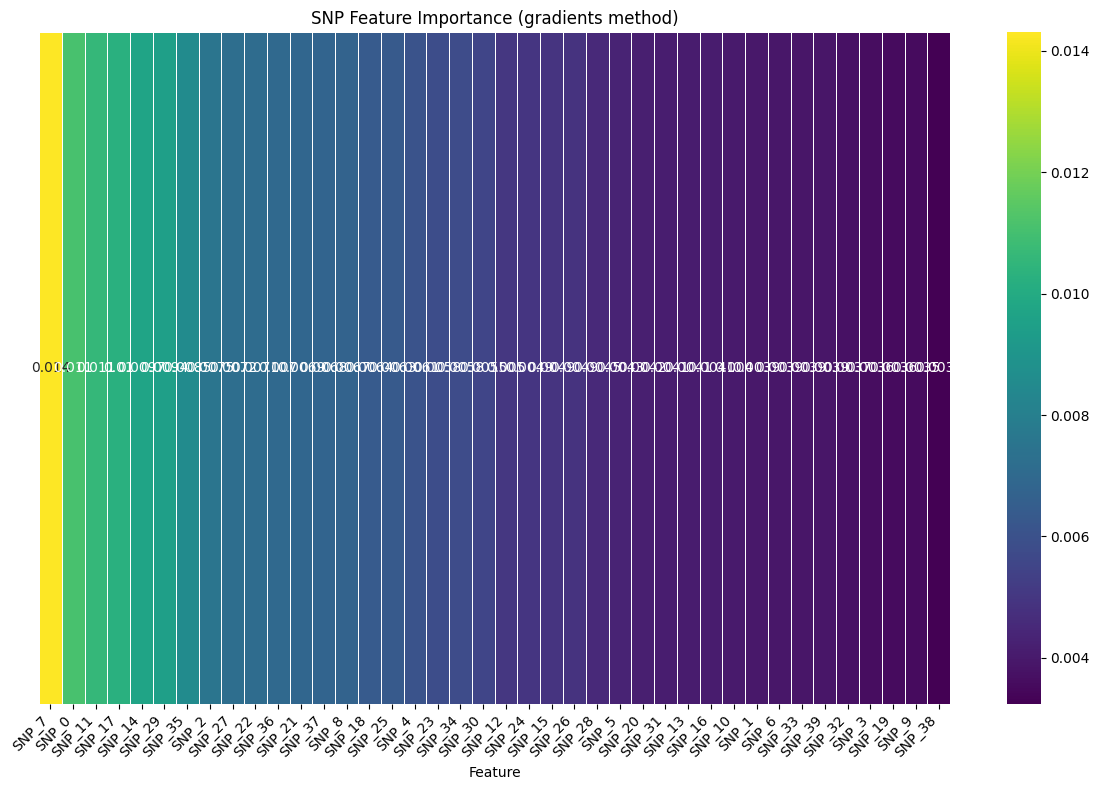

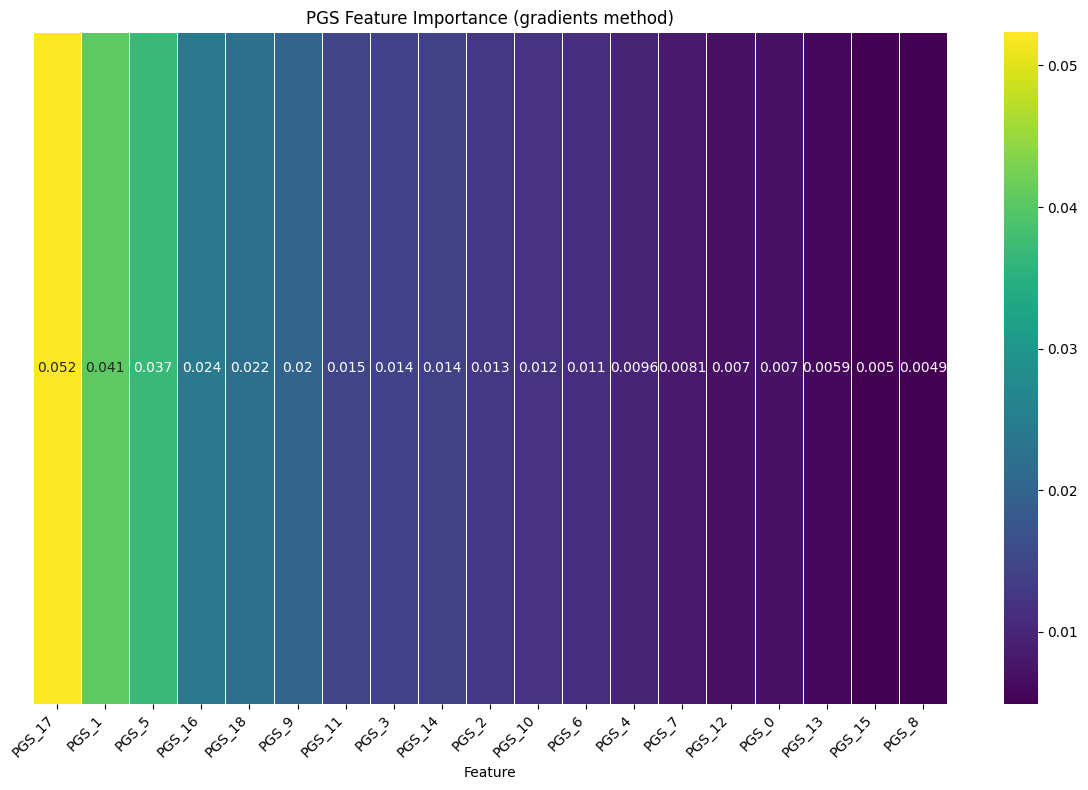

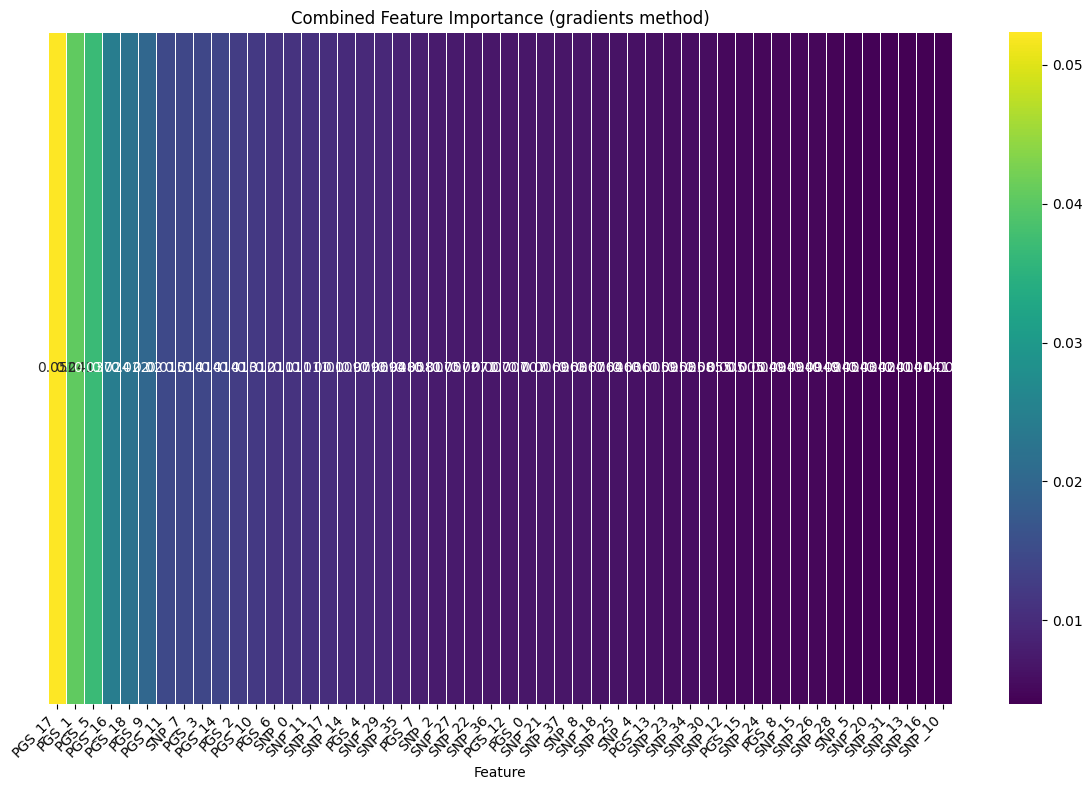

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import roc_auc_score
import pandas as pd
from tqdm import tqdm
import copy

def calculate_feature_importance_gradients(model, X_snp, X_pgs, target_class=1):
    """
    Рассчитывает важность признаков на основе градиентов
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    X_snp_tensor = torch.FloatTensor(X_snp).to(device).requires_grad_(True)
    X_pgs_tensor = torch.FloatTensor(X_pgs).to(device).requires_grad_(True)
    
    output = model(X_snp_tensor, X_pgs_tensor)
    
    if output.dim() == 1:
        target = torch.ones_like(output)
    else:
        target = torch.zeros_like(output)
        target[:, 0] = 1.0
    
    model.zero_grad()
    
    output.backward(gradient=target)
    
    snp_gradients = X_snp_tensor.grad.abs().mean(dim=0).cpu().numpy()
    pgs_gradients = X_pgs_tensor.grad.abs().mean(dim=0).cpu().numpy()
    
    return snp_gradients, pgs_gradients

def manual_permutation_importance(model, X_snp, X_pgs, y, n_repeats=10):
    """
    Вручную реализованный метод пермутации для расчета важности признаков
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        X_snp_tensor = torch.FloatTensor(X_snp).to(device)
        X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
        baseline_preds = model(X_snp_tensor, X_pgs_tensor).cpu().numpy()
        if baseline_preds.ndim > 1:
            baseline_preds = baseline_preds[:, 0]
        baseline_score = roc_auc_score(y, baseline_preds)
    
    snp_importance = np.zeros(X_snp.shape[1])
    pgs_importance = np.zeros(X_pgs.shape[1])
    
    for i in tqdm(range(X_snp.shape[1]), desc="Calculating SNP importance"):
        importance = 0
        for _ in range(n_repeats):
            X_snp_permuted = X_snp.copy()
            np.random.shuffle(X_snp_permuted[:, i])
            
            with torch.no_grad():
                X_snp_tensor = torch.FloatTensor(X_snp_permuted).to(device)
                X_pgs_tensor = torch.FloatTensor(X_pgs).to(device)
                permuted_preds = model(X_snp_tensor, X_pgs_tensor).cpu().numpy()
                if permuted_preds.ndim > 1:
                    permuted_preds = permuted_preds[:, 0]
                permuted_score = roc_auc_score(y, permuted_preds)
            
            importance += baseline_score - permuted_score
        
        snp_importance[i] = importance / n_repeats
    
    for i in tqdm(range(X_pgs.shape[1]), desc="Calculating PGS importance"):
        importance = 0
        for _ in range(n_repeats):
            X_pgs_permuted = X_pgs.copy()
            np.random.shuffle(X_pgs_permuted[:, i])
            
            with torch.no_grad():
                X_snp_tensor = torch.FloatTensor(X_snp).to(device)
                X_pgs_tensor = torch.FloatTensor(X_pgs_permuted).to(device)
                permuted_preds = model(X_snp_tensor, X_pgs_tensor).cpu().numpy()
                if permuted_preds.ndim > 1:
                    permuted_preds = permuted_preds[:, 0]
                permuted_score = roc_auc_score(y, permuted_preds)
            
            importance += baseline_score - permuted_score
        
        pgs_importance[i] = importance / n_repeats
    
    return snp_importance, pgs_importance

def plot_feature_importance_heatmap(importance_values, feature_names, title, figsize=(12, 8)):
    """
    Создает тепловую карту важности признаков
    """
    plt.figure(figsize=figsize)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    }).sort_values('Importance', ascending=False)
    
    top_n = min(50, len(importance_df))
    importance_df = importance_df.head(top_n)
    
    heatmap_data = importance_df.set_index('Feature')['Importance'].to_frame().T
    
    ax = sns.heatmap(heatmap_data, annot=True, cmap='viridis', linewidths=.5)
    
    plt.yticks([])
    plt.xticks(rotation=45, ha='right')  # Поворачиваем метки оси X
    
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

def analyze_and_visualize_feature_importance(model, X_snp, X_pgs, y, 
                                            snp_feature_names=None, pgs_feature_names=None,
                                            method='permutation'):
    """
    Анализирует и визуализирует важность признаков
    """
    if snp_feature_names is None:
        snp_feature_names = [f'SNP_{i}' for i in range(X_snp.shape[1])]
    if pgs_feature_names is None:
        pgs_feature_names = [f'PGS_{i}' for i in range(X_pgs.shape[1])]
    
    if method == 'gradients':
        print("Calculating feature importance using gradients...")
        snp_importance, pgs_importance = calculate_feature_importance_gradients(model, X_snp, X_pgs)
    else:  # 'permutation'
        print("Calculating feature importance using permutation method...")
        snp_importance, pgs_importance = manual_permutation_importance(model, X_snp, X_pgs, y)
    
    plot_feature_importance_heatmap(
        snp_importance, snp_feature_names,
        f'SNP Feature Importance ({method} method)'
    )
    
    plot_feature_importance_heatmap(
        pgs_importance, pgs_feature_names,
        f'PGS Feature Importance ({method} method)'
    )
    
    combined_importance = np.concatenate([snp_importance, pgs_importance])
    combined_names = snp_feature_names + pgs_feature_names
    
    plot_feature_importance_heatmap(
        combined_importance, combined_names,
        f'Combined Feature Importance ({method} method)'
    )
    
    return {
        'snp_importance': dict(zip(snp_feature_names, snp_importance)),
        'pgs_importance': dict(zip(pgs_feature_names, pgs_importance))
    }

importance_results_grad = analyze_and_visualize_feature_importance(
    combined_model, X_val_all, X_val_pgs, y_val,
    method='gradients'
)

snp_importance_df = pd.DataFrame({
    'Feature': list(importance_results_grad['snp_importance'].keys()),
    'Importance': list(importance_results_grad['snp_importance'].values())
}).sort_values('Importance', ascending=False)

pgs_importance_df = pd.DataFrame({
    'Feature': list(importance_results_grad['pgs_importance'].keys()),
    'Importance': list(importance_results_grad['pgs_importance'].values())
}).sort_values('Importance', ascending=False)
